In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

# Helper functions

In [2]:
def draw_mols(mols, frag, legends, file_path, cut_down_size = False):
    
    patt = Chem.MolFromSmiles(frag)
    hit_ats = [mol.GetSubstructMatch(patt) for mol in mols]
    hit_bonds = []
    for mol, hit_at in zip(mols, hit_ats):
        hit_bond = []
        for bond in patt.GetBonds():
            aid1 = hit_at[bond.GetBeginAtomIdx()]
            aid2 = hit_at[bond.GetEndAtomIdx()]
            hit_bond.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        hit_bonds.append(hit_bond)
    
    # code with help from the OG greg landrum: https://gist.github.com/greglandrum/d5f12058682f6b336905450e278d3399
    if cut_down_size:
        mols = mols[0:10]
        legends = legends[0:10]
        hit_ats = hit_ats[0:10]
        hit_bonds = hit_bonds[0:10]
    molsPerRow = 5
    subImgSize= (500,500)
    nRows = len(mols) // molsPerRow
    if len(mols) % molsPerRow:
        nRows += 1
    fullSize = (molsPerRow * subImgSize[0], nRows * subImgSize[1])
    d2d = rdMolDraw2D.MolDraw2DCairo(fullSize[0],fullSize[1], subImgSize[0], subImgSize[1])
    
    # Set the drawing options
    d2d.drawOptions().legendFontSize=100
    d2d.drawOptions().useBWAtomPalette()
    color = matplotlib.colors.ColorConverter().to_rgb('lightskyblue')

    hit_atom_cols = [{b: color for b in hit_at} for hit_at in hit_ats]
    hit_bond_cols = [{b: color for b in hb} for hb in hit_bonds]
    d2d.DrawMolecules(mols,legends=legends, highlightAtoms=hit_ats,
                                  highlightBonds=hit_bonds, highlightAtomColors=hit_atom_cols, highlightBondColors=hit_bond_cols)
    d2d.FinishDrawing()
    open(file_path,'wb+').write(d2d.GetDrawingText())

In [3]:
def plot_fragments_within_cpd_groups(df, path, frag_smi_col = 'fragment_SMILES', cpd_smi_col = 'SMILES', name_col = '', file_name_col = ''):
    for frag, smalldf in df.groupby(frag_smi_col):
        display(Chem.MolFromSmiles(frag))
        mols = [Chem.MolFromSmiles(smi) for smi in smalldf[cpd_smi_col]]
        display(Draw.MolsToGridImage(mols))
        legends = ''
        if name_col != '':
            legends = list(smalldf[name_col])
            
        name = frag
        if file_name_col !='':
            name = list(smalldf[file_name_col])[0]
        draw_mols(mols, frag, legends=legends, file_path=path + name + '.png')

In [4]:
def preprocess_df_sort_according_to_hit(df, hit_col_dict={}, rd_col_name = 'Round', frag_smi_col = 'fragment_SMILES', cpd_smi_col = 'SMILES', frag_prefix = 'SF'):
    fragment_smiles_name = {}
    
    # get the hit rates for each fragment
    fixed_df = pd.DataFrame()
    for rd_col in hit_col_dict.keys():
        smalldf = df[df[rd_col_name] == rd_col]
        smalldf['HIT'] = list(smalldf[hit_col_dict[rd_col]])
        fixed_df = pd.concat([fixed_df,smalldf])
    df = fixed_df.copy()
    hit_rates = []
    frags = []
    total_nums = []
    for frag, smalldf in df.groupby(frag_smi_col):
        hits = [1.0 if x==True else 0.0 for x in list(smalldf['HIT'])]
        hit_rate = sum(hits) / len(hits)
        frags.append(frag)
        hit_rates.append(hit_rate)
        total_nums.append(sum(hits))
        if sum(hits) > 4:
            print(sum(hits))
            print(hit_rate, len(hits))
            display(smalldf)
    # sort original df based on hit rate
    frag_hit_dict = dict(zip(frags, hit_rates))
    frag_num_dict = dict(zip(frags, total_nums))
    df['hit_rate'] = [frag_hit_dict[frag] for frag in list(df[frag_smi_col])]
    df['number_of_cpds_for_frag'] = [frag_num_dict[frag] for frag in list(df[frag_smi_col])]
    df = df.sort_values(by = ['hit_rate', frag_smi_col], ascending = False)
    df = df.reset_index(drop = True)
    
    # name fragments based on Fx (x is 1 thru N sorted based on descending hit rate)
    sorted_indices = sorted(range(len(hit_rates)), key=lambda k: (hit_rates[k],frags[k]), reverse = True)
    frags = [frags[i] for i in sorted_indices]
    frag_name_dict = dict(zip(frags, [frag_prefix + str(i+1) for i in range(len(frags))]))
    df['fragment_name'] = [frag_name_dict[frag] for frag in list(df[frag_smi_col])]
    
    # finally, return df so df is ONLY hits
    hits = df[[x==1.0 for x in list(df['HIT'])]]
    nonhits = df[[x==0.0 for x in list(df['HIT'])]]

    return(hits,nonhits)


In [5]:
def plot_fragment_hit_rates(df, path, threshold_above_1 = True, fig_size = (3.5, 3), num_col = 'number_of_cpds_for_frag', hit_rate_col = 'hit_rate', frag_name_col = 'fragment_name'):

    # plot fragments hit rates
    fig, ax = plt.subplots(figsize = fig_size, dpi = 300)

    if threshold_above_1:
        df = df[df['number_of_cpds_for_frag'] > 1]
    xs = [int(x) for x in list(df[num_col])]
    ys = list(df[hit_rate_col])
    labs = df[frag_name_col]
    plt.bar(x=labs, height=ys)

    rects = ax.patches
    for rect, label in zip(rects, xs):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, ' ' + str(label), fontsize = 8, rotation = 90, ha="center", va="bottom"
        )

    plt.xticks(fontsize = 8, rotation = 90)
    plt.yticks(fontsize = 8, rotation = 90)
    plt.ylabel('Hit Rate for Fragment')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(path + '.png')
    plt.savefig(path + '.svg')
    plt.show()


# Round1 Pilot

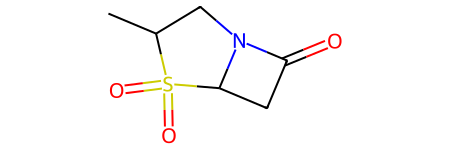

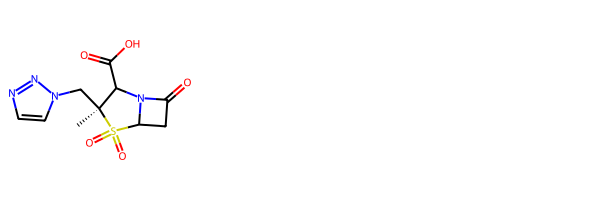

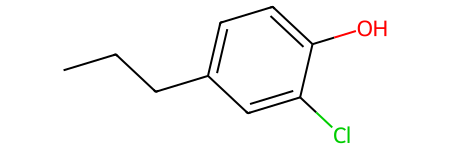

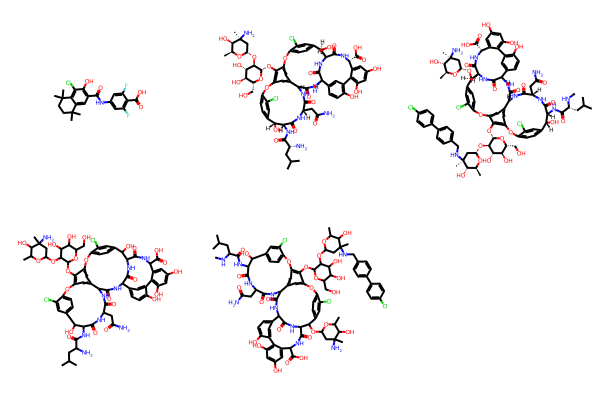

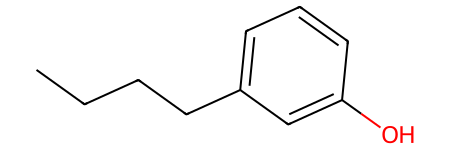

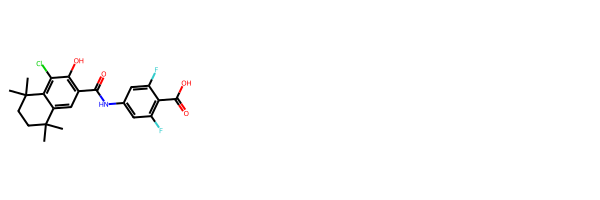

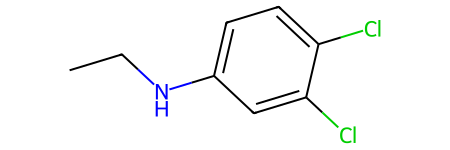

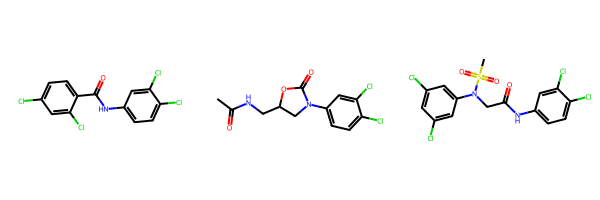

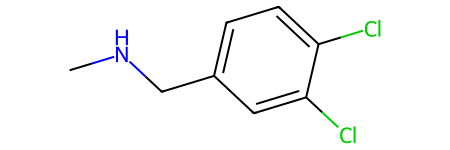

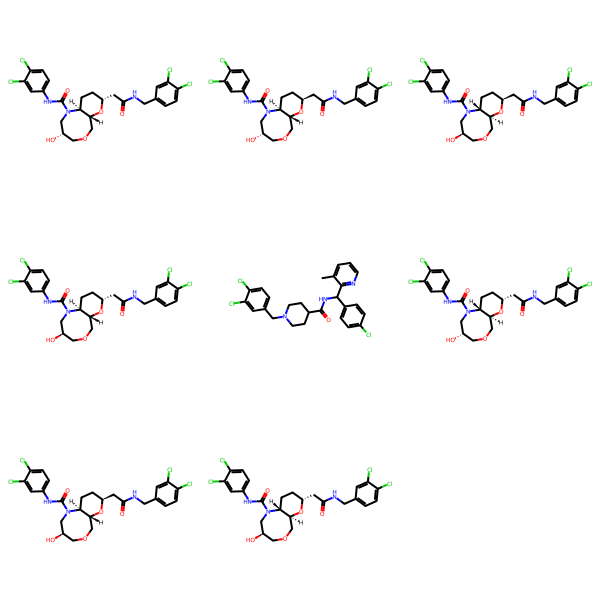

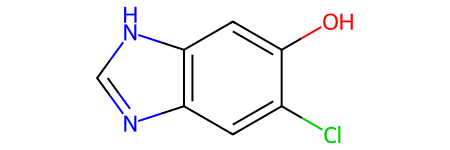

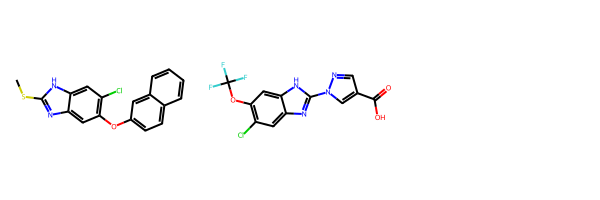

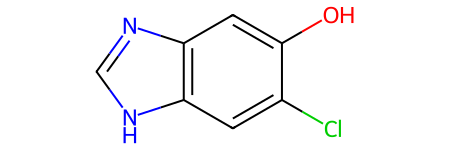

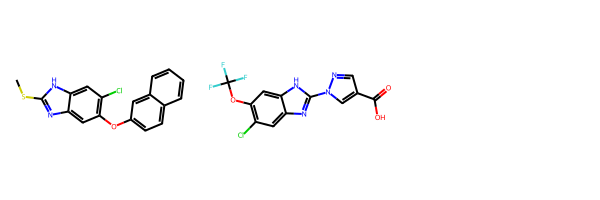

In [6]:
fulldf = pd.read_csv('../out/combined_cpd_and_frag_results_up_through_round5_01182023.csv')
rd1 = fulldf[fulldf['Round'] == 'Round1-Pilot']
rd1 = rd1[rd1['Confirmed-Hit'] == True]
path = '../figs/intermediate_data/fragments/pilot-rd1/'
plot_fragments_within_cpd_groups(rd1, path = path)

# Rounds 1 - 6 for SA frags

In [7]:
fulldf = pd.read_csv('../out/combined_cpd_and_frag_results_up_through_round5_01182023.csv')
rd6 = pd.read_csv('../out/round6_cleaned_results.csv')

fulldf = pd.concat([fulldf, rd6])

5.0
0.7142857142857143 7


/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_99199/3468604532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smalldf['HIT'] = list(smalldf[hit_col_dict[rd_col]])
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_99199/3468604532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smalldf['HIT'] = list(smalldf[hit_col_dict[rd_col]])
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_99199/3468604532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Round             ID           Name  \
202  Round5-GDB11,17+Broad  BRD-A81029847  BRD-A81029847   
205  Round5-GDB11,17+Broad  BRD-A63931499  BRD-A63931499   
212  Round5-GDB11,17+Broad  BRD-A65826572  BRD-A65826572   
215  Round5-GDB11,17+Broad  BRD-A94433478  BRD-A94433478   
218  Round5-GDB11,17+Broad  BRD-A52163878  BRD-A52163878   
221  Round5-GDB11,17+Broad  BRD-K25654212  BRD-K25654212   
229  Round5-GDB11,17+Broad  BRD-K34657753  BRD-K34657753   

                                                SMILES        fragment_SMILES  \
202  O[C@@H](CN1CCC2(CC1)C[C@@H](O)c1cc(ccc1O2)F)c1...  CCC1=CC=C(Cl)C(Cl)=C1   
205  Cc1ccc2c(c1)[C@H](O)CC1(CCN(CC1)C[C@@H](O)c1cc...  CCC1=CC=C(Cl)C(Cl)=C1   
212  COc1ccc2c(c1)[C@H](O)CC1(CCN(CC1)C[C@@H](O)c1c...  CCC1=CC=C(Cl)C(Cl)=C1   
215  COc1ccc2c(c1)OC1(CCN(CC1)C[C@@H](O)c1ccc(c(c1)...  CCC1=CC=C(Cl)C(Cl)=C1   
218  O[C@@H](CN1CCC2(CC1)C[C@@H](O)c1ccccc1O2)c1ccc...  CCC1=CC=C(Cl)C(Cl)=C1   
221  CC1(C)CC(=O)c2c(cc(cc2O1)OCC(=O)c1ccc(c(c1)Cl)...  CCC1=CC=C(Cl)C(Cl)=C1   
229        OC(=O)c1ccccc1Nc1ccc(cc1)CCc1ccc(c(c1)Cl)Cl  CCC1=CC=C(Cl)C(Cl)=C1   

     Rep1-OD  Rep2-OD Hit-OD Confirmed-Hit    HIT  
202   0.0563      NaN   True           NaN   True  
205   0.8715      NaN  False           NaN  False  
212   0.0687      NaN   True           NaN   True  
215   0.0690      NaN   True           NaN   True  
218   0.0566      NaN   True           NaN   True  
221   1.1708      NaN  False           NaN  False  
229   0.0717      NaN   True           NaN   True

5.0
0.8333333333333334 6


Round                      ID                              Name  \
1   Round1-Pilot  BRD-K60417814-001-01-2                              Dioa   
10  Round1-Pilot  BRD-K32533226-001-01-3                        AGN 195183   
13  Round1-Pilot  BRD-K00003706-003-01-9                     Norvancomycin   
15  Round1-Pilot  BRD-K00003704-316-01-9                       Oritavancin   
17  Round1-Pilot  BRD-A08791201-003-01-4  CID: 13366009; Vancomycin analog   
40  Round1-Pilot  BRD-A33352494-316-01-6    BDBM420318 (Vancomycin analog)   

                                               SMILES        fragment_SMILES  \
1   CCCC[C@@]1(Cc2cc(OCC(O)=O)c(Cl)c(Cl)c2C1=O)C1C...  CCCC1=CC=C(O)C(Cl)=C1   
10  CC1(C)CCC(C)(C)c2c(Cl)c(O)c(cc12)C(=O)Nc1cc(F)...  CCCC1=CC=C(O)C(Cl)=C1   
13  [H][C@@]1(C[C@](C)(N)[C@H](O)[C@H](C)O1)O[C@@H...  CCCC1=CC=C(O)C(Cl)=C1   
15  [H][C@@]1(C[C@](C)(NCc2ccc(cc2)-c2ccc(Cl)cc2)[...  CCCC1=CC=C(O)C(Cl)=C1   
17  CC(C)CC(N)C(=O)NC1C(O)c2ccc(Oc3cc4cc(Oc5ccc(cc...  CCCC1=CC=C(O)C(Cl)=C1   
40  CNC(CC(C)C)C(=O)NC1C(O)c2ccc(Oc3cc4cc(Oc5ccc(c...  CCCC1=CC=C(O)C(Cl)=C1   

    Rep1-OD  Rep2-OD Hit-OD Confirmed-Hit    HIT  
1    0.0586   0.0450   True         False  False  
10   0.0488   0.0465   True          True   True  
13   0.0476   0.0465   True          True   True  
15   0.0580   0.0534   True          True   True  
17   0.0476   0.0444   True          True   True  
40   0.1769   0.1181   True          True   True

6.0
0.2857142857142857 21


Round                      ID  \
4                      Round1-Pilot  BRD-A35072058-001-01-4   
14                     Round1-Pilot  BRD-K05739625-001-01-6   
16                     Round1-Pilot  BRD-A40436789-001-01-0   
22                     Round1-Pilot  BRD-A74510491-001-01-0   
24                     Round1-Pilot  BRD-K98498749-001-01-8   
26                     Round1-Pilot  BRD-K43746259-001-01-8   
31                     Round1-Pilot  BRD-A07467764-001-01-5   
33                     Round1-Pilot  BRD-A54804966-001-01-7   
42                     Round1-Pilot  BRD-K23982137-001-01-1   
159  Round4-Enamine Fragments+Broad           BRD-K23971431   
162  Round4-Enamine Fragments+Broad           BRD-A66536342   
165  Round4-Enamine Fragments+Broad           BRD-K56775383   
170  Round4-Enamine Fragments+Broad           BRD-K32414785   
173  Round4-Enamine Fragments+Broad           BRD-K75390623   
176  Round4-Enamine Fragments+Broad           BRD-K58057411   
179  Round4-Enamine Fragments+Broad           BRD-K90422985   
182  Round4-Enamine Fragments+Broad           BRD-K78399109   
185  Round4-Enamine Fragments+Broad           BRD-K25297725   
188  Round4-Enamine Fragments+Broad           BRD-K25805146   
191  Round4-Enamine Fragments+Broad           BRD-K79933602   
194  Round4-Enamine Fragments+Broad           BRD-A61084483   

                                                  Name  \
4                                        AKOS033468015   
14        2,4-dichloro-N-(3,4-dichlorophenyl)benzamide   
16                                      CID: 132456975   
22                                         954718-28-6   
24                                    CBKinase1_006540   
26                                    CBKinase1_011491   
31                                      CID: 132466084   
33                                        MLS000707329   
42   N-(3,4-dichlorophenyl)-2-{[5-(3,4-dichlorophen...   
159                                      BRD-K23971431   
162                                      BRD-A66536342   
165                                      BRD-K56775383   
170                                      BRD-K32414785   
173                                      BRD-K75390623   
176                                      BRD-K58057411   
179                                      BRD-K90422985   
182                                      BRD-K78399109   
185                                      BRD-K25297725   
188                                      BRD-K25805146   
191                                      BRD-K79933602   
194                                      BRD-A61084483   

                                                SMILES  \
4                 Clc1ccc(cc1Cl)N1CCC(Sc2nnc[nH]2)C1=O   
14              Clc1ccc(C(=O)Nc2ccc(Cl)c(Cl)c2)c(Cl)c1   
16   CC1(CCN1C(=O)CCc1ccc(Cl)cc1Cl)C(=O)Nc1ccc(Cl)c...   
22               CC(=O)NCC1CN(C(=O)O1)c1ccc(Cl)c(Cl)c1   
24   CS(=O)(=O)N(CC(=O)Nc1ccc(Cl)c(Cl)c1)c1cc(Cl)cc...   
26          Clc1ccc(NC(=O)CCc2nc(no2)-c2ccccc2Cl)cc1Cl   
31       Cc1ccc(OCCN2CCC2(C)C(=O)Nc2ccc(Cl)c(Cl)c2)cc1   
33   CNc1nc(SC(C)C(=O)Nc2ccc(Cl)c(Cl)c2)nc(n1)N1CCOCC1   
42   Cn1c(SCC(=O)Nc2ccc(Cl)c(Cl)c2)nnc1-c1ccc(Cl)c(...   
159        CCCC1=CC(=O)N=C(N1)SCC(=O)Nc1ccc(c(c1)Cl)Cl   
162        C[C@@H](Sc1ccc(cc1)C)C(=O)Nc1ccc(c(c1)Cl)Cl   
165       CCNc1nc(nc(n1)N(C)C)SCC(=O)Nc1ccc(c(c1)Cl)Cl   
170  CCN(CCN(C)C)c1c(nc2ccc(cn12)C(=O)Nc1ccc(c(c1)C...   
173  Fc1ccc(cc1)N1C=CC(=O)C(=N1)C(=O)Nc1ccc(c(c1)Cl)Cl   
176   CCn1c(nnc1-c1ccc(cc1)Br)SCC(=O)Nc1ccc(c(c1)Cl)Cl   
179                  Clc1ccc(cc1Cl)NC(=O)c1ccc2nnsc2c1   
182  Clc1ccc(cc1)N1C(=O)c2ccccc2N=C1SCC(=O)Nc1ccc(c...   
185           COc1ccc(c(c1)C)CCCC(=O)Nc1ccc(c(c1)Cl)Cl   
188       Clc1ccc(cc1Cl)NC(=O)CSc1nnc(o1)-c1ccc(cc1)Br   
191  Fc1ccc(cc1)-n1c(nnc1-c1cccs1)SCC(=O)Nc1ccc(c(c...   
194     C[C@@H](Sc1nc(cc(n1)C)C)C(=O)Nc1ccc(c(c1)Cl)Cl   

            fragment_SMILES  Rep1-OD  Rep2-OD Hit-OD Confirmed-Hit    HIT  
4    CCNC1=CC

8.0
0.5 16


Round                      ID                    Name  \
5   Round1-Pilot  BRD-K94319360-001-01-8  BRD-K94319360-001-01-8   
6   Round1-Pilot  BRD-K53482787-001-01-8  BRD-K53482787-001-01-8   
11  Round1-Pilot  BRD-K36648601-001-01-0  BRD-K36648601-001-01-0   
12  Round1-Pilot  BRD-K72531819-001-01-1  BRD-K72531819-001-01-1   
18  Round1-Pilot  BRD-A60560486-001-01-8             946373-33-7   
21  Round1-Pilot  BRD-K26931203-001-01-4  BRD-K26931203-001-01-4   
27  Round1-Pilot  BRD-A00377910-001-01-6           AKOS030448647   
28  Round1-Pilot  BRD-A34034658-001-01-9          CID: 132455857   
30  Round1-Pilot  BRD-A15964565-001-01-2           AKOS030448638   
32  Round1-Pilot  BRD-A23783868-001-01-0            MLS003121713   
34  Round1-Pilot  BRD-K83820188-001-01-8  BRD-K83820188-001-01-8   
38  Round1-Pilot  BRD-K28984605-001-01-5  BRD-K28984605-001-01-5   
39  Round1-Pilot  BRD-A33528215-001-01-7          CID: 132456566   
41  Round1-Pilot  BRD-K55448741-001-01-2  BRD-K55448741-001-01-2   
44  Round1-Pilot  BRD-A68828239-001-01-1             941029-41-0   
45  Round1-Pilot  BRD-K74443966-001-01-8             ZINC5027549   

                                               SMILES         fragment_SMILES  \
5   O[C@H]1COC[C@@H]2O[C@H](CC(=O)NCc3ccc(Cl)c(Cl)...  CNCC1=CC=C(Cl)C(Cl)=C1   
6   O[C@H]1COC[C@H]2O[C@@H](CC(=O)NCc3ccc(Cl)c(Cl)...  CNCC1=CC=C(Cl)C(Cl)=C1   
11  O[C@H]1COC[C@H]2O[C@H](CC(=O)NCc3ccc(Cl)c(Cl)c...  CNCC1=CC=C(Cl)C(Cl)=C1   
12  O[C@@H]1COC[C@@H]2O[C@H](CC(=O)NCc3ccc(Cl)c(Cl...  CNCC1=CC=C(Cl)C(Cl)=C1   
18     Clc1ccc(cc1Cl)C1NC(=O)NC2=C1C(=O)N(CC1CCCO1)C2  CNCC1=CC=C(Cl)C(Cl)=C1   
21  O[C@@H]1COC[C@H]2O[C@@H](CC(=O)NCc3ccc(Cl)c(Cl...  CNCC1=CC=C(Cl)C(Cl)=C1   
27    Clc1ccc(cc1Cl)C1NC(=O)NC2=C1C(=O)N(CCN1CCCC1)C2  CNCC1=CC=C(Cl)C(Cl)=C1   
28  Fc1ccc(cc1)C(NC(=O)C1CCN(Cc2ccc(Cl)c(Cl)c2)CC1...  CNCC1=CC=C(Cl)C(Cl)=C1   
30       OCCCN1CC2=C(C(NC(=O)N2)c2ccc(Cl)c(Cl)c2)C1=O  CNCC1=CC=C(Cl)C(Cl)=C1   
32  Cc1cccnc1C(NC(=O)C1CCN(Cc2ccc(Cl)c(Cl)c2)CC1)c...  CNCC1=CC=C(Cl)C(Cl)=C1   
34  O[C@H]1COC[C@@H]2O[C@@H](CC(=O)NCc3ccc(Cl)c(Cl...  CNCC1=CC=C(Cl)C(Cl)=C1   
38  O[C@@H]1COC[C@H]2O[C@H](CC(=O)NCc3ccc(Cl)c(Cl)...  CNCC1=CC=C(Cl)C(Cl)=C1   
39  Cc1cccnc1C(NC(=O)C1CCN(Cc2ccc(Cl)c(Cl)c2)CC1)c...  CNCC1=CC=C(Cl)C(Cl)=C1   
41  O[C@@H]1COC[C@@H]2O[C@@H](CC(=O)NCc3ccc(Cl)c(C...  CNCC1=CC=C(Cl)C(Cl)=C1   
44       COCCN1CC2=C(C(NC(=O)N2)c2ccc(Cl)c(Cl)c2)C1=O  CNCC1=CC=C(Cl)C(Cl)=C1   
45   CC1(C)CC(CC(C)(C)N1)NC(=O)c1cc(Cl)c(Cl)cc1C(O)=O  CNCC1=CC=C(Cl)C(Cl)=C1   

    Rep1-OD  Rep2-OD Hit-OD Confirmed-Hit    HIT  
5    0.0768   0.0741   True         False  False  
6    0.0837   0.0757   True          True   True  
11   0.0563   0.0553   True          True   True  
12   0.1304   0.1096   True          True   True  
18   1.0431   0.8376  False           NaN    NaN  
21   0.0708   0.0568   True          True   True  
27   0.9073   0.8656  False           NaN    NaN  
28   0.8287   0.9206  False           NaN    NaN  
30   0.7636   0.8072  False           NaN    NaN  
32   0.1462   0.2922   True          True   True  
34   0.1068   0.1004   True          True   True  
38   0.0561   0.0691   True          True   True  
39   0.6582   0.7086  False           NaN    NaN  
41   0.0886   0.0693   True          True   True  
44   0.7787   0.8375  False           NaN    NaN  
45   0.8231   0.7429  False           NaN    NaN

5.0
0.8333333333333334 6


Round             ID           Name  \
203  Round5-GDB11,17+Broad  BRD-A81029847  BRD-A81029847   
206  Round5-GDB11,17+Broad  BRD-A63931499  BRD-A63931499   
213  Round5-GDB11,17+Broad  BRD-A65826572  BRD-A65826572   
216  Round5-GDB11,17+Broad  BRD-A94433478  BRD-A94433478   
219  Round5-GDB11,17+Broad  BRD-A52163878  BRD-A52163878   
223  Round5-GDB11,17+Broad  BRD-K79529816  BRD-K79529816   

                                                SMILES        fragment_SMILES  \
203  O[C@@H](CN1CCC2(CC1)C[C@@H](O)c1cc(ccc1O2)F)c1...  OCC1=CC=C(Cl)C(Cl)=C1   
206  Cc1ccc2c(c1)[C@H](O)CC1(CCN(CC1)C[C@@H](O)c1cc...  OCC1=CC=C(Cl)C(Cl)=C1   
213  COc1ccc2c(c1)[C@H](O)CC1(CCN(CC1)C[C@@H](O)c1c...  OCC1=CC=C(Cl)C(Cl)=C1   
216  COc1ccc2c(c1)OC1(CCN(CC1)C[C@@H](O)c1ccc(c(c1)...  OCC1=CC=C(Cl)C(Cl)=C1   
219  O[C@@H](CN1CCC2(CC1)C[C@@H](O)c1ccccc1O2)c1ccc...  OCC1=CC=C(Cl)C(Cl)=C1   
223          CC(C)(C)c1cn2cccc(c2n1)OCc1ccc(c(c1)Cl)Cl  OCC1=CC=C(Cl)C(Cl)=C1   

     Rep1-OD  Rep2-OD Hit-OD Confirmed-Hit    HIT  
203   0.0563      NaN   True           NaN   True  
206   0.8715      NaN  False           NaN  False  
213   0.0687      NaN   True           NaN   True  
216   0.0690      NaN   True           NaN   True  
219   0.0566      NaN   True           NaN   True  
223   0.0846      NaN   True           NaN   True

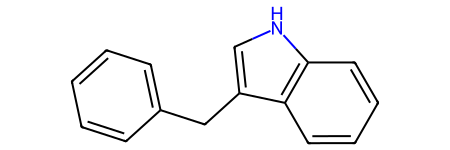

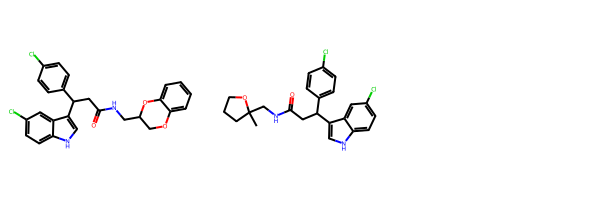

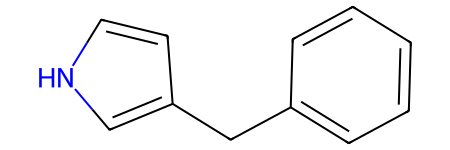

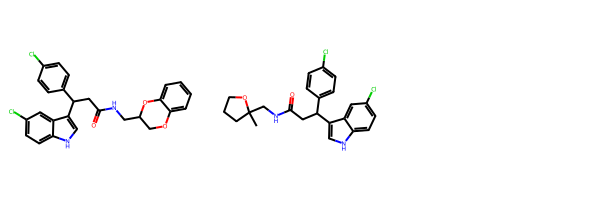

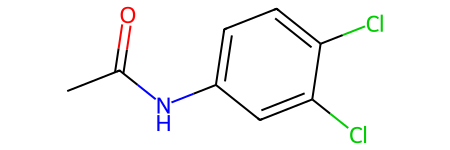

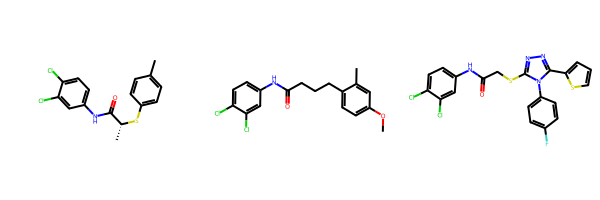

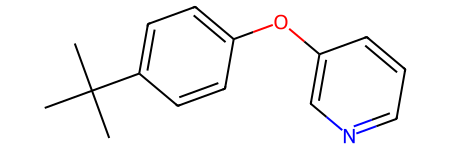

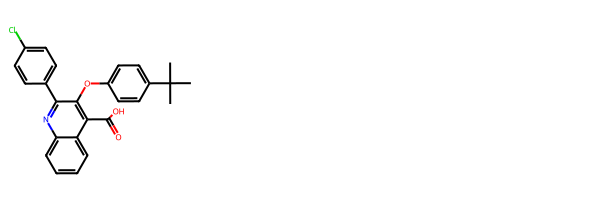

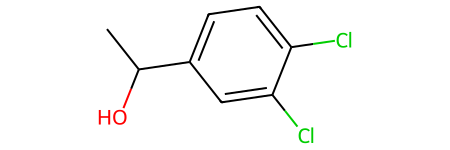

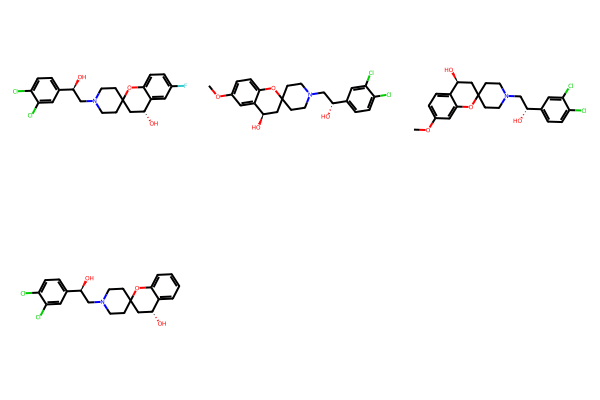

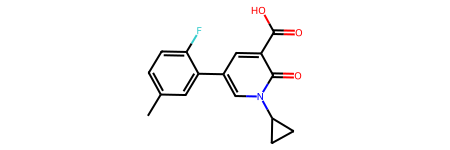

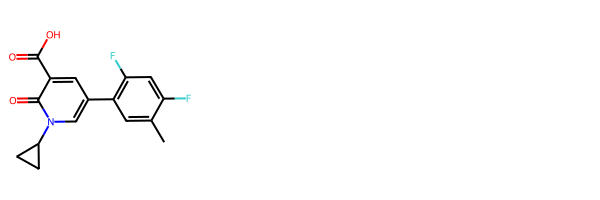

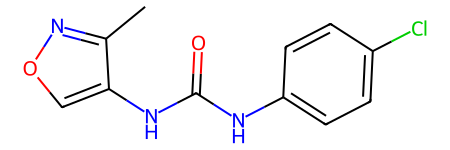

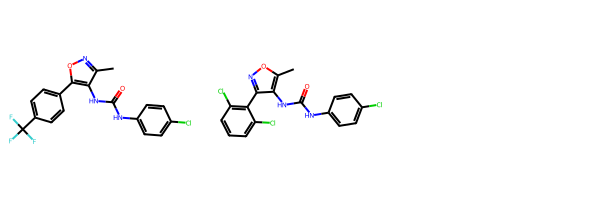

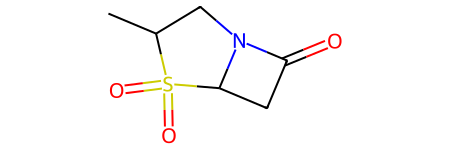

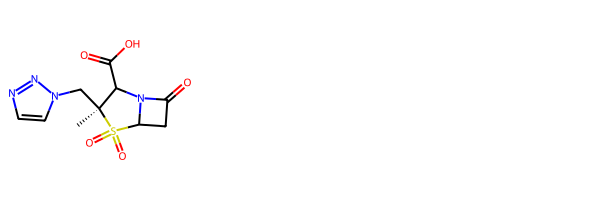

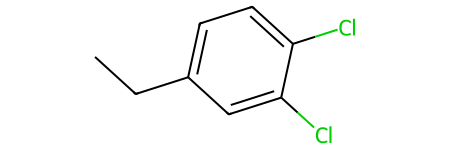

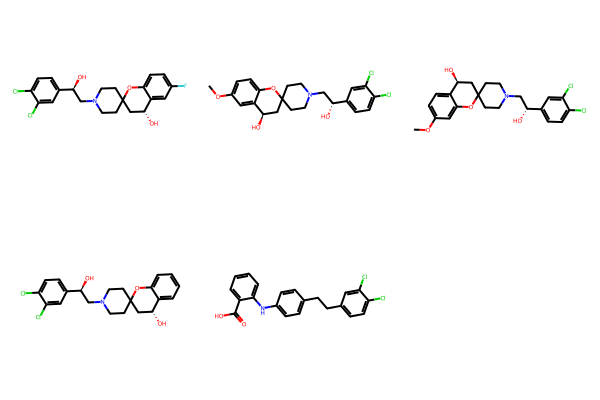

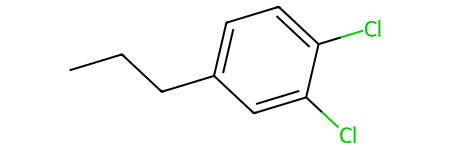

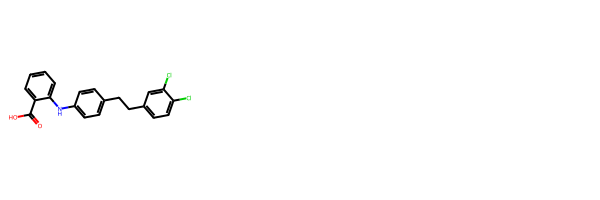

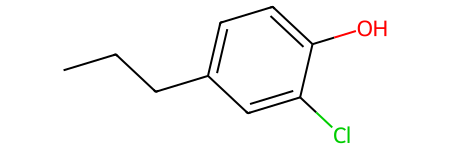

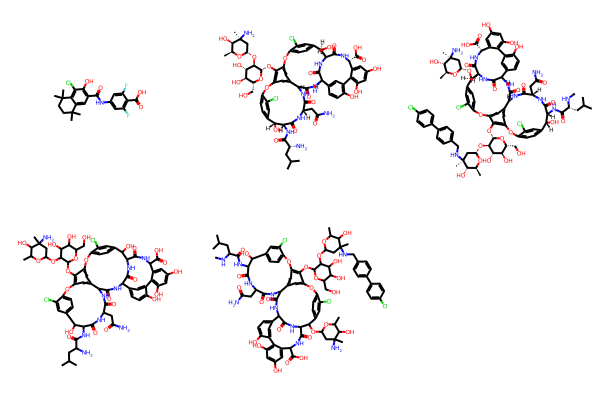

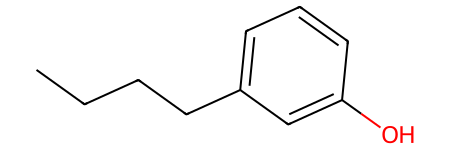

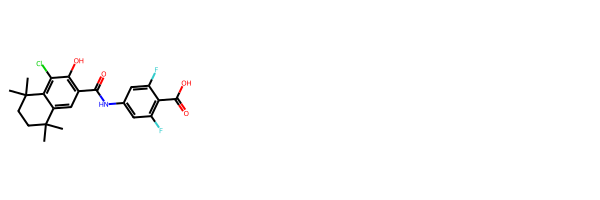

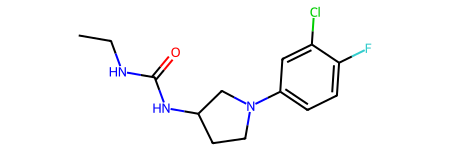

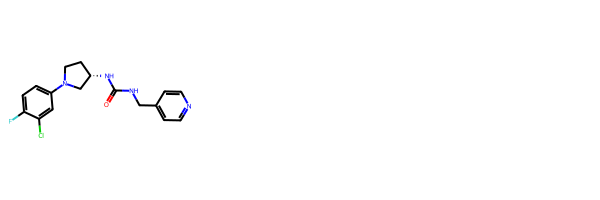

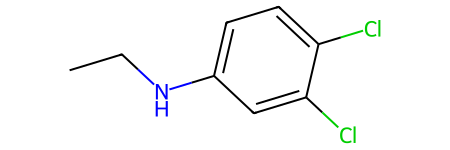

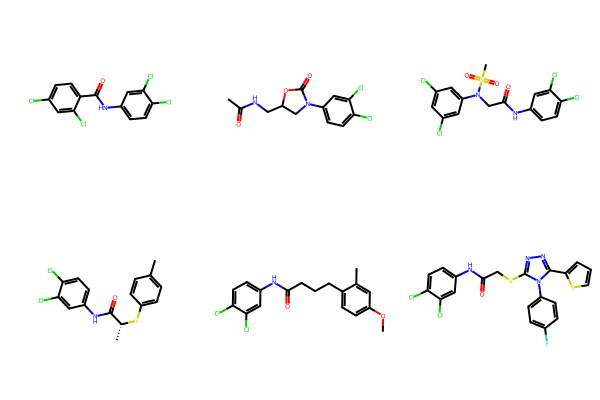

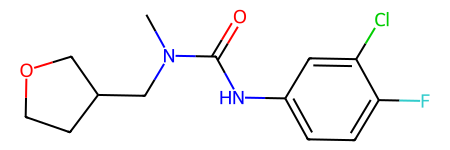

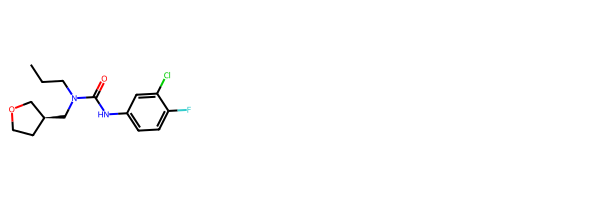

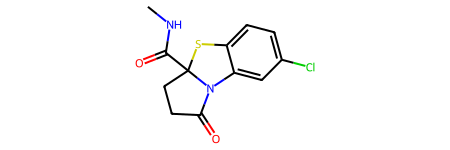

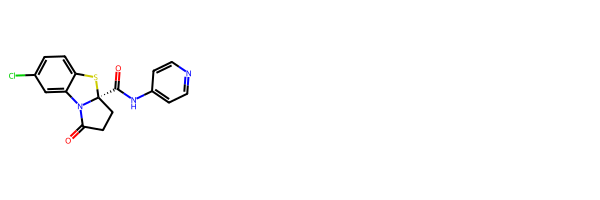

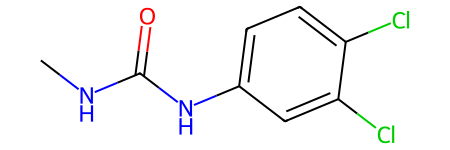

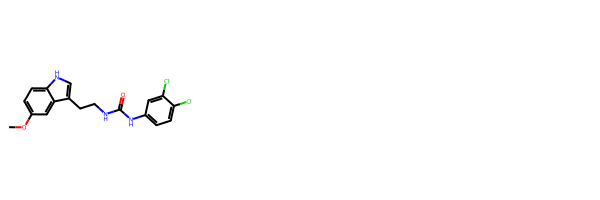

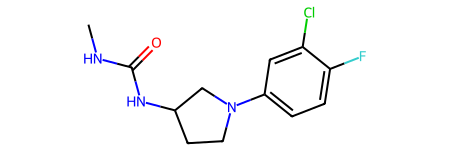

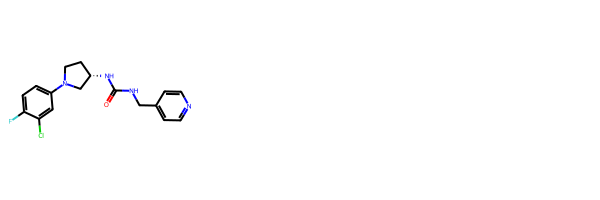

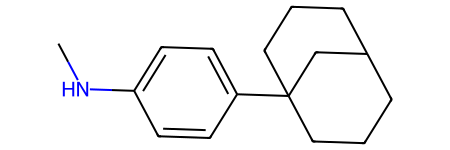

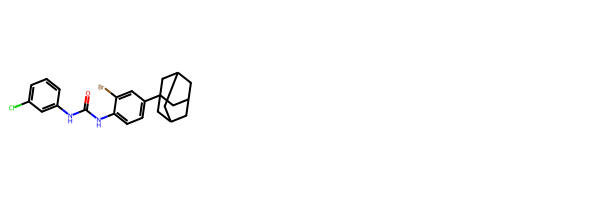

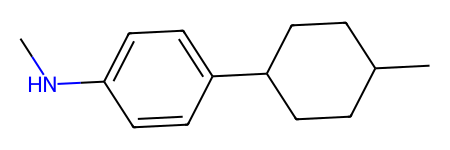

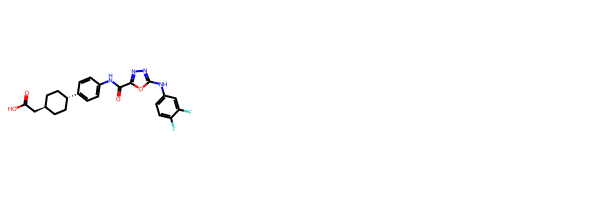

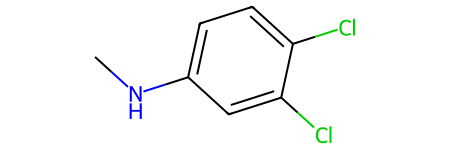

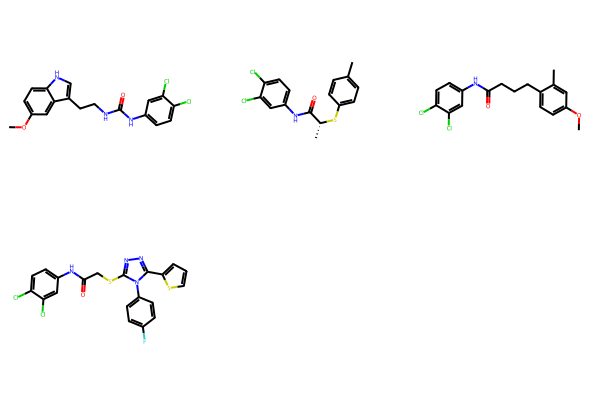

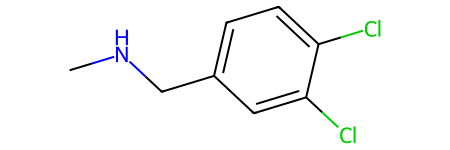

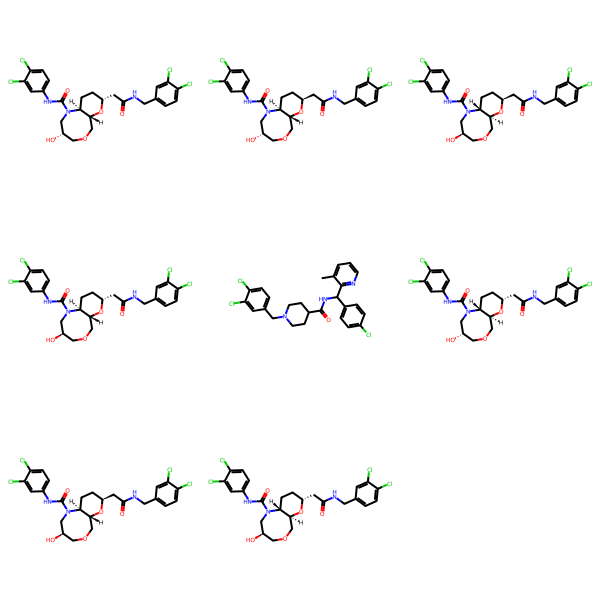

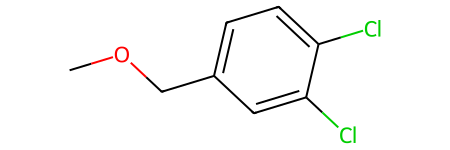

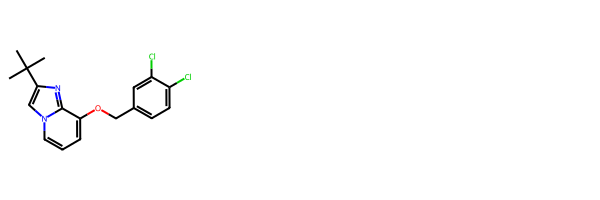

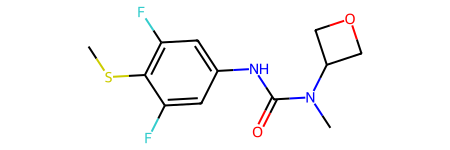

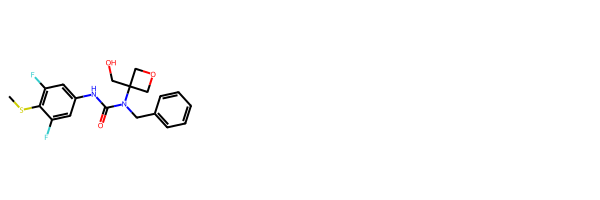

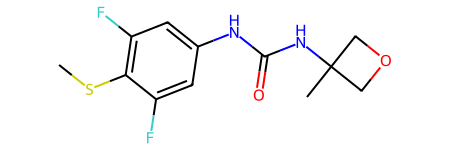

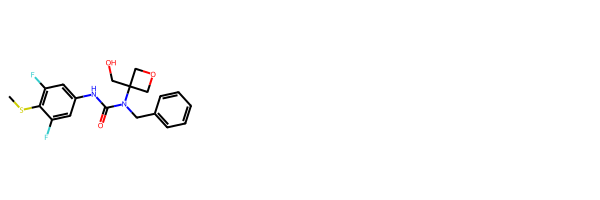

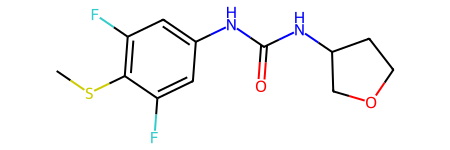

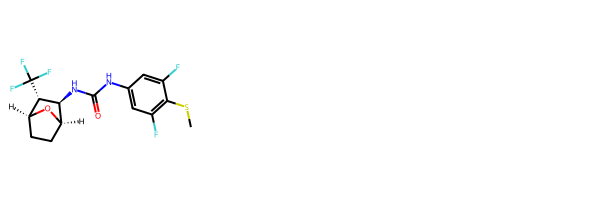

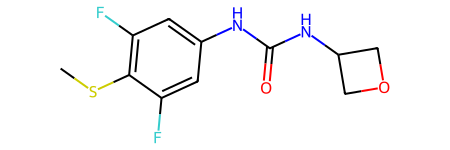

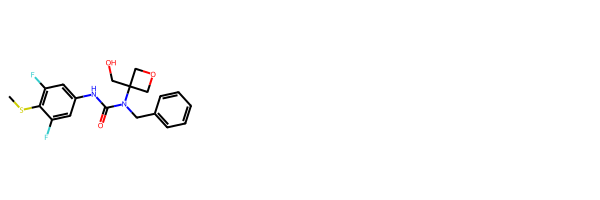

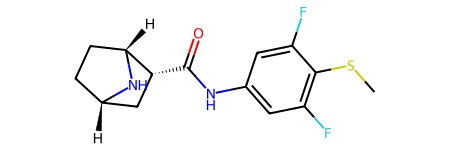

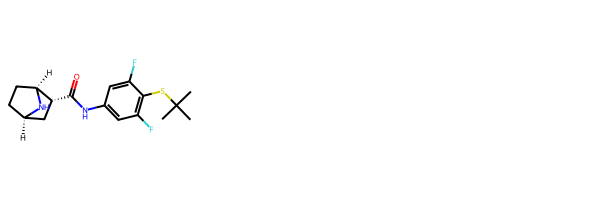

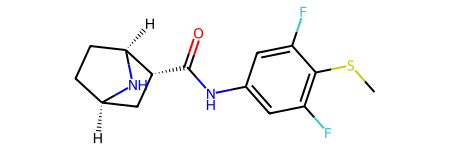

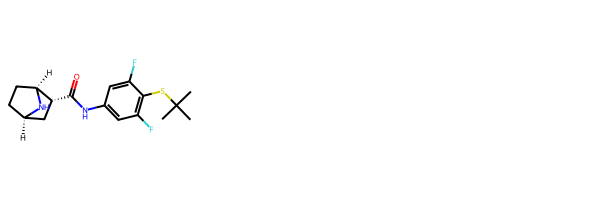

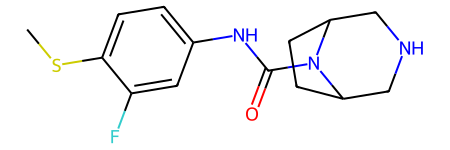

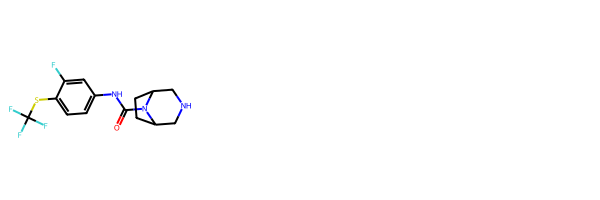

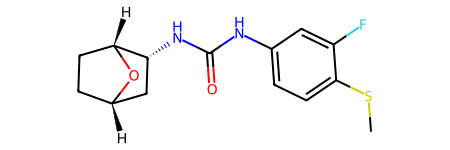

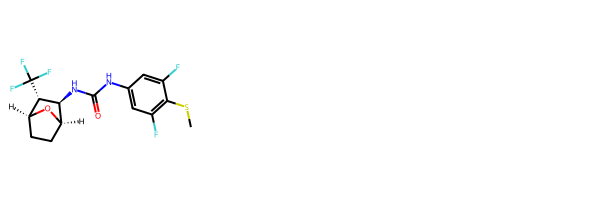

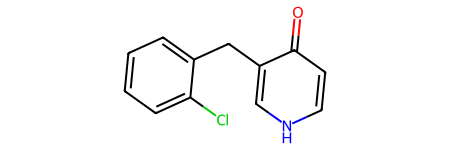

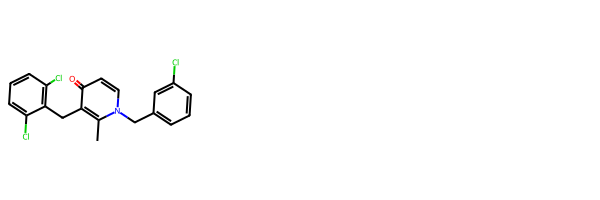

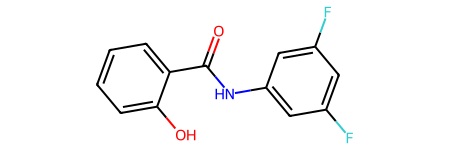

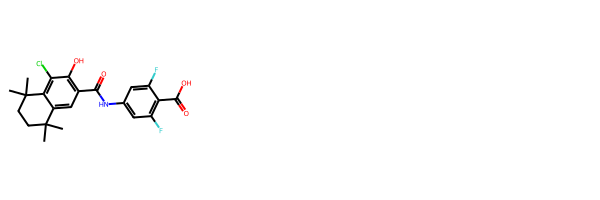

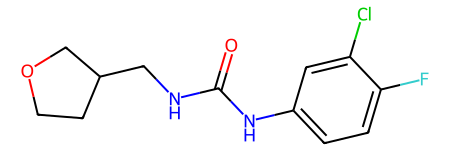

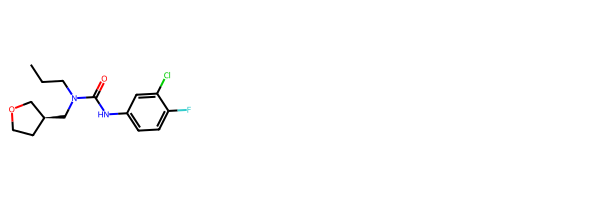

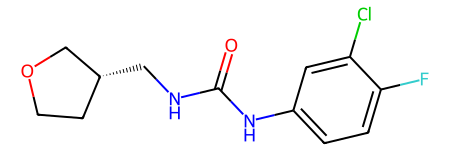

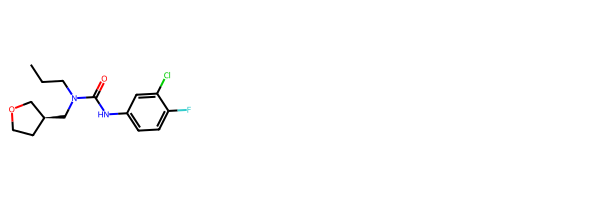

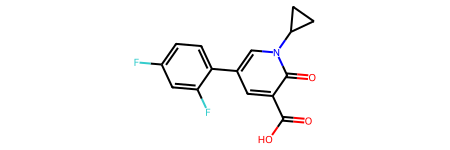

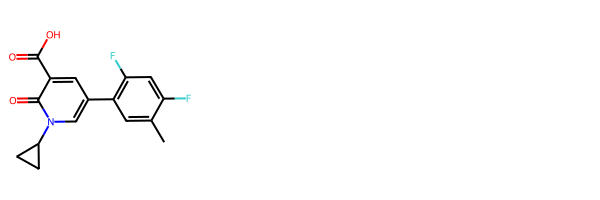

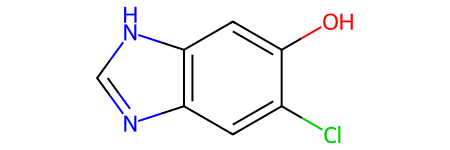

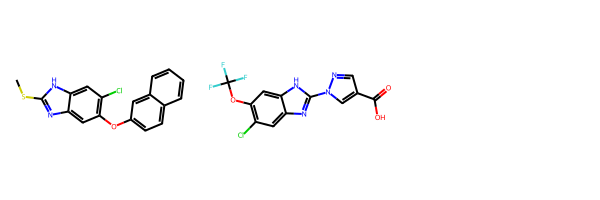

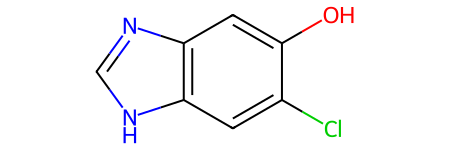

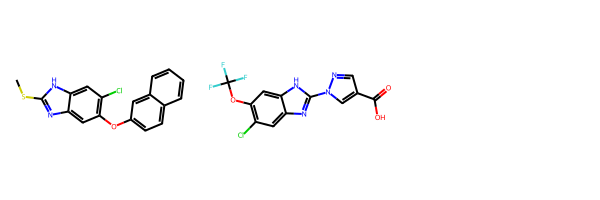

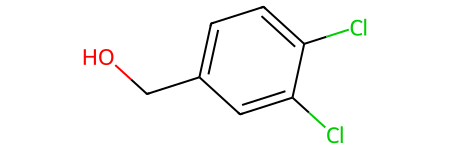

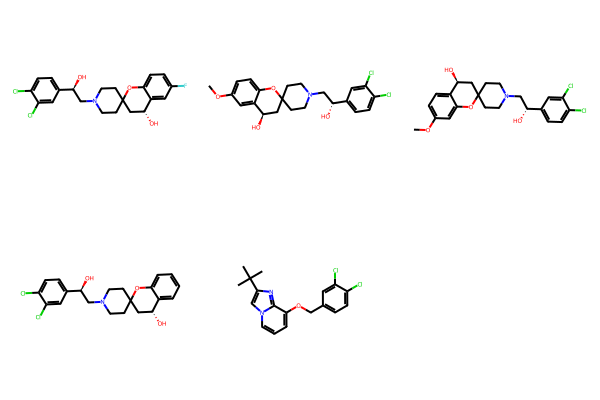

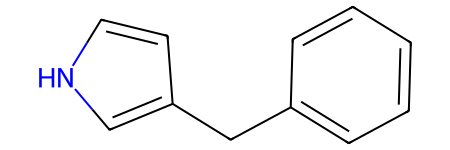

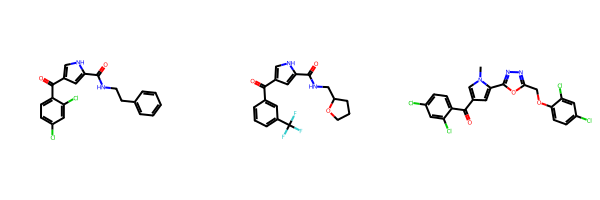

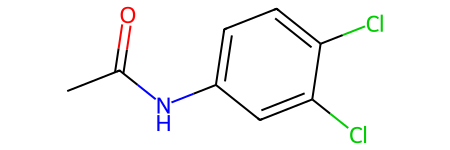

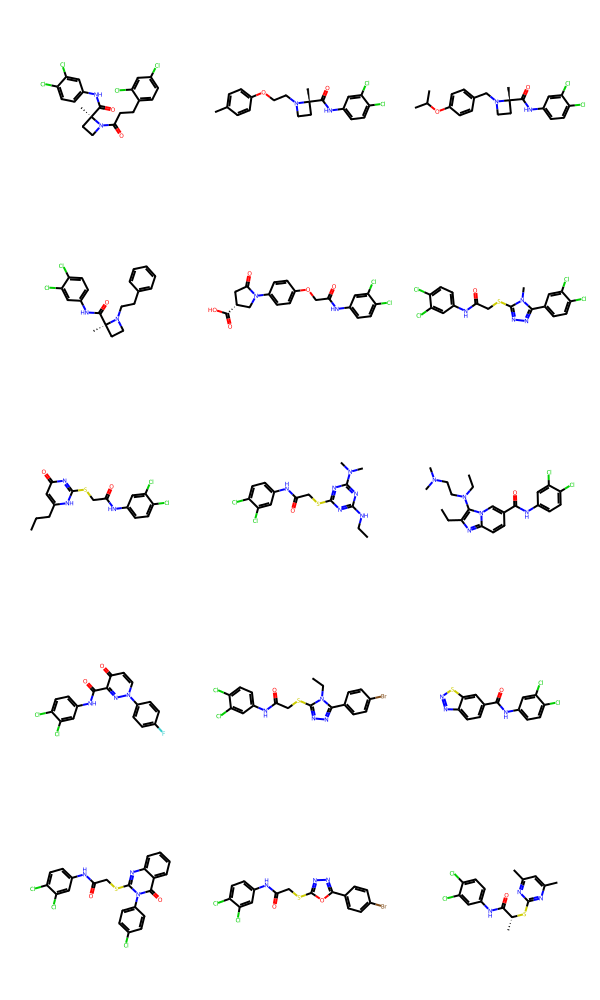

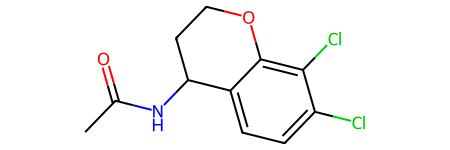

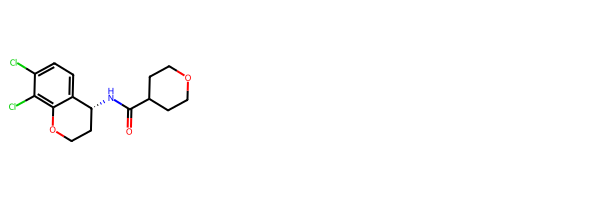

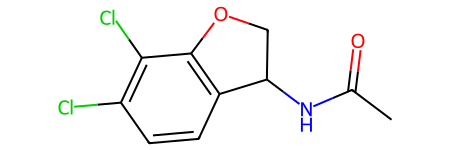

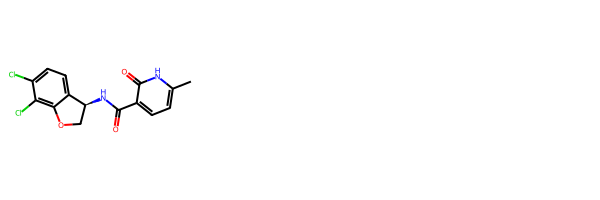

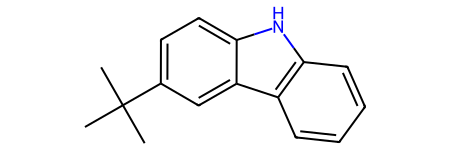

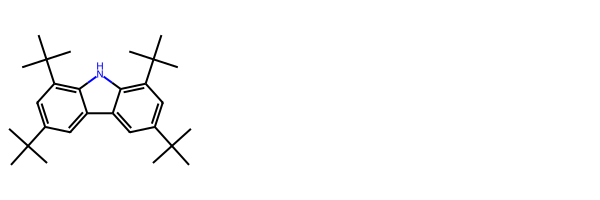

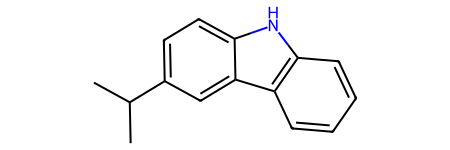

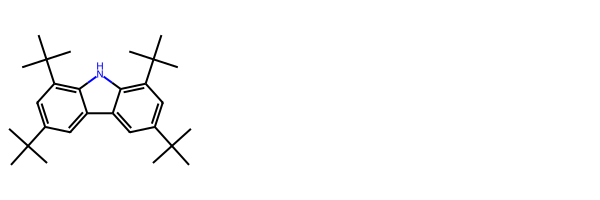

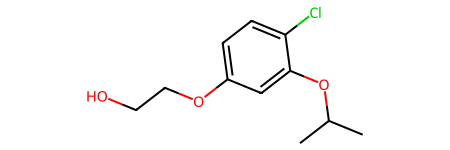

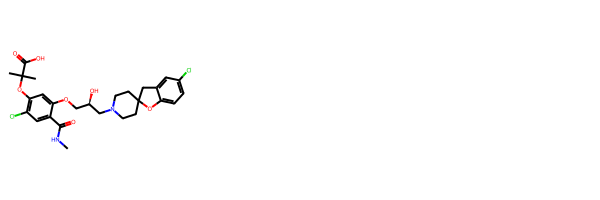

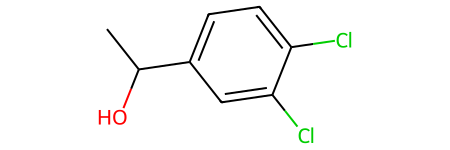

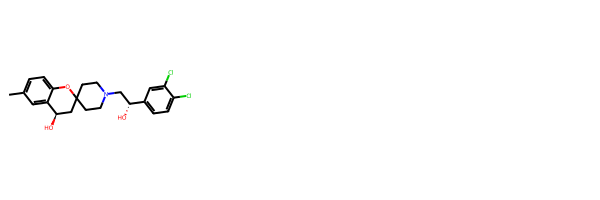

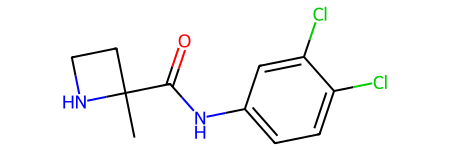

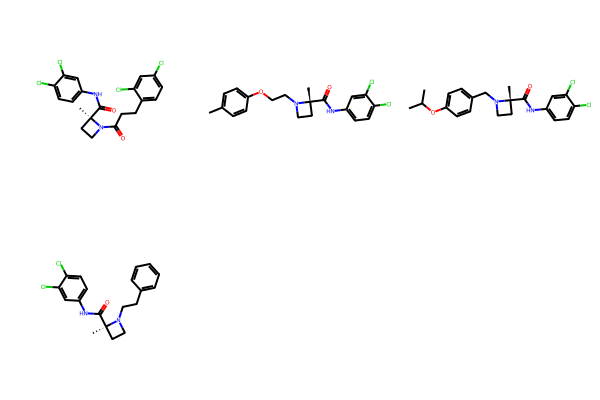

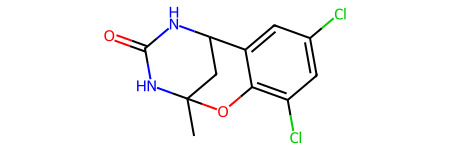

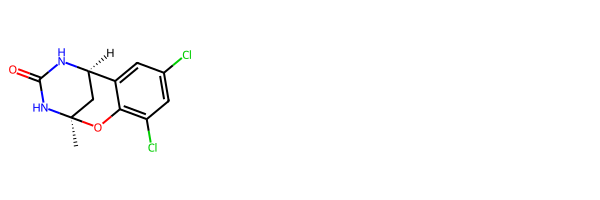

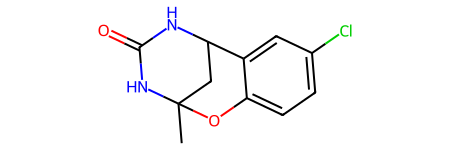

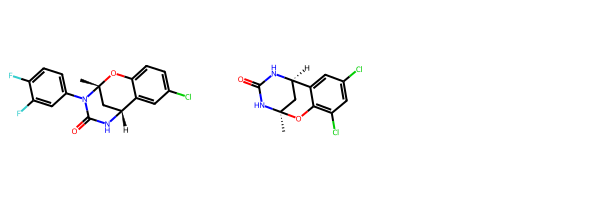

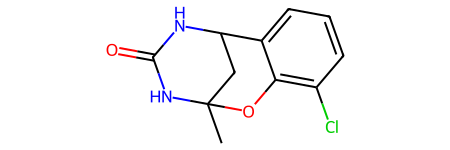

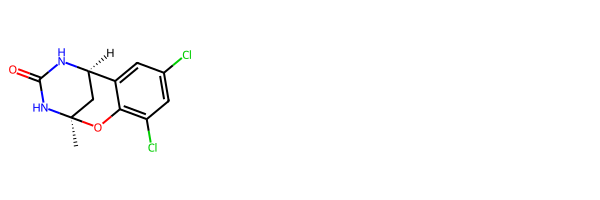

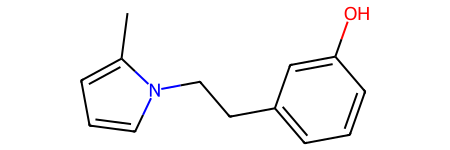

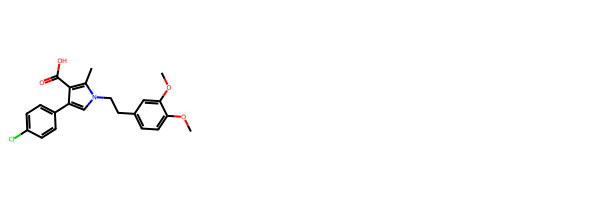

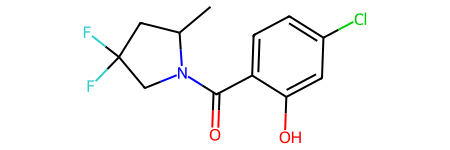

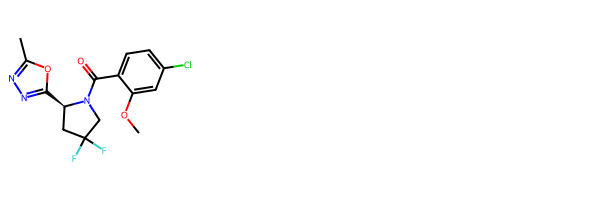

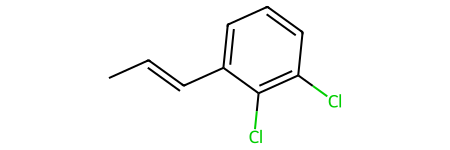

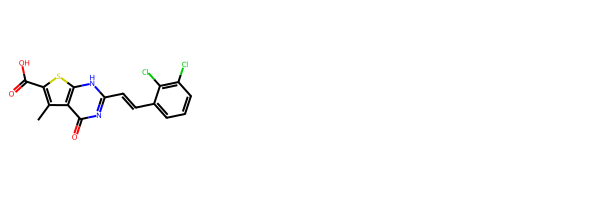

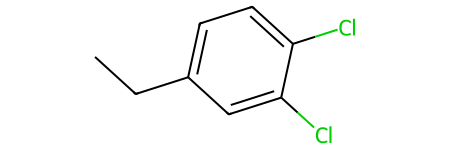

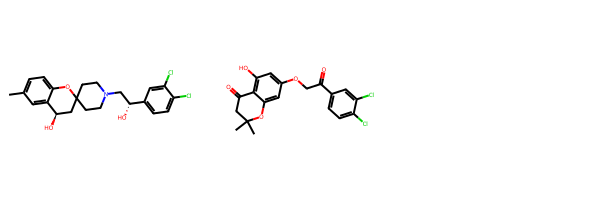

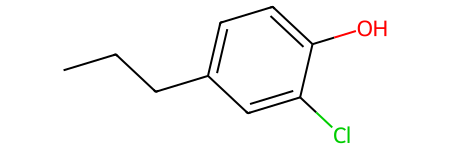

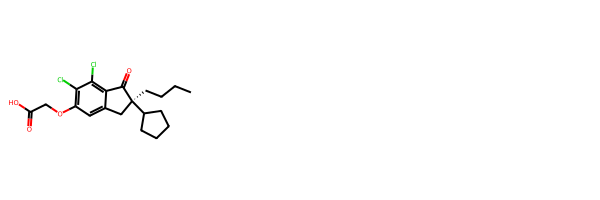

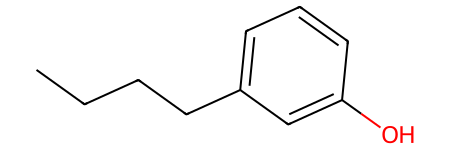

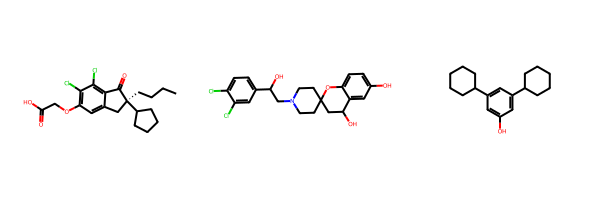

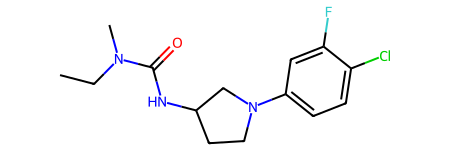

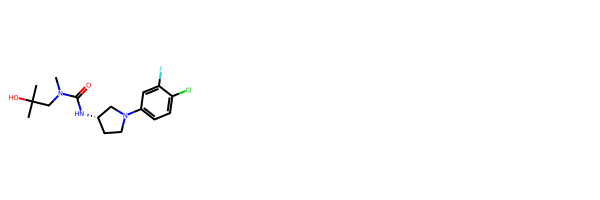

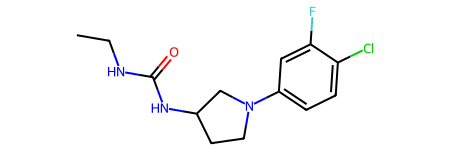

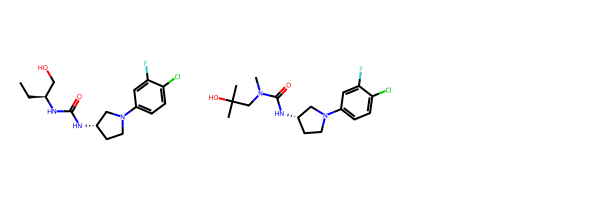

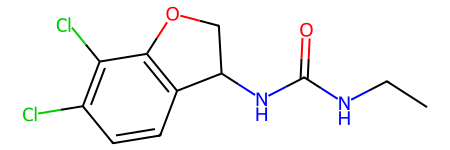

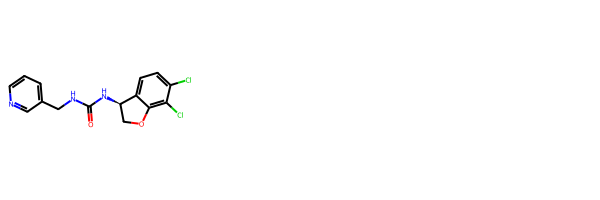

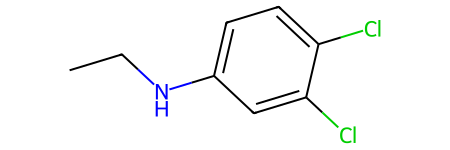

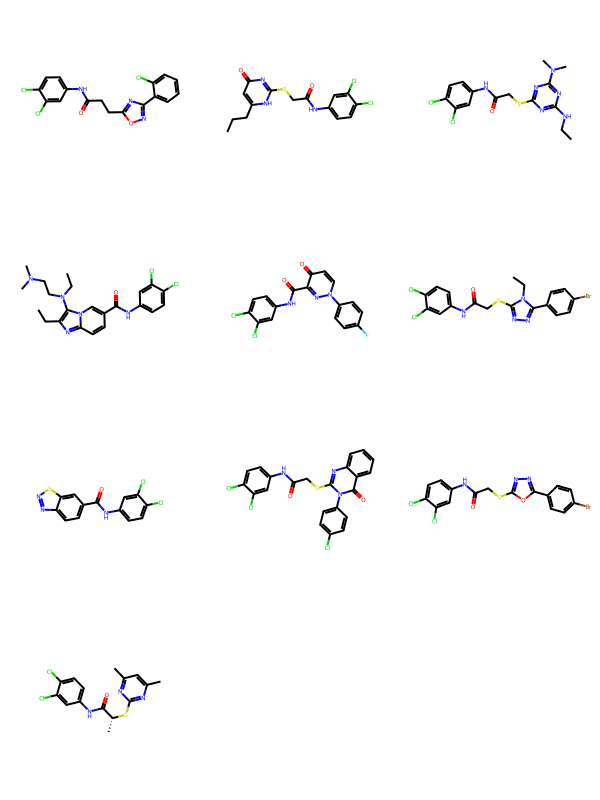

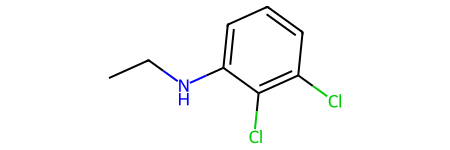

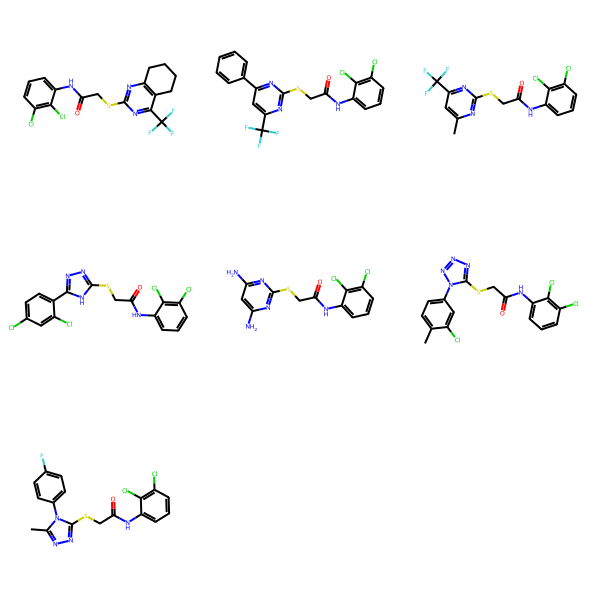

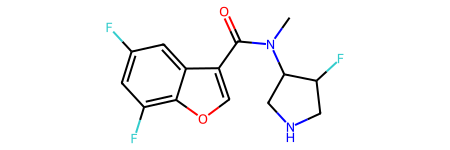

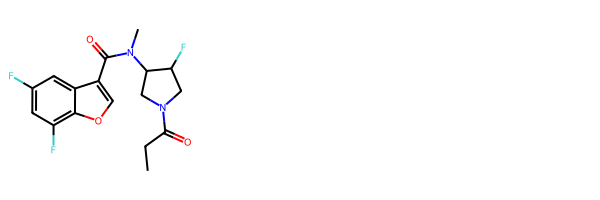

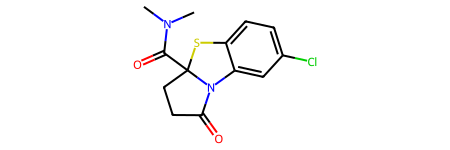

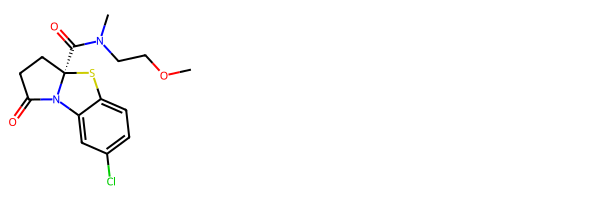

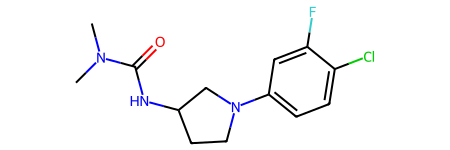

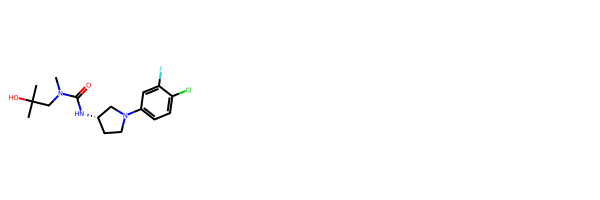

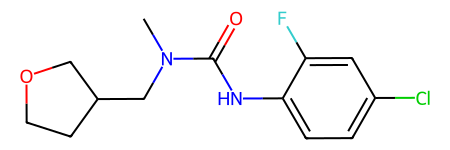

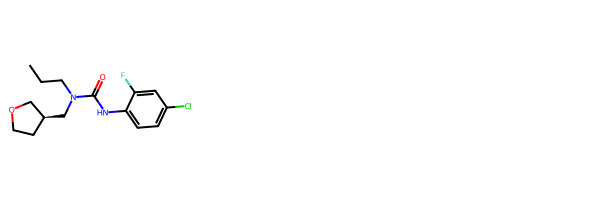

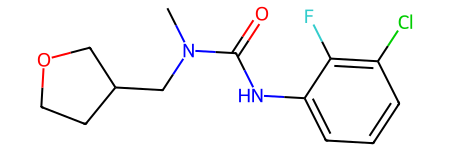

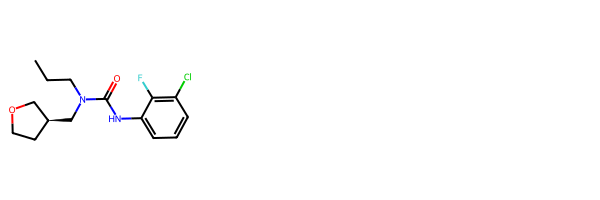

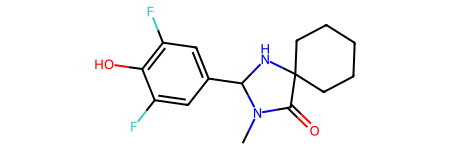

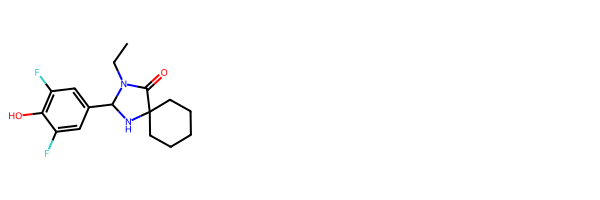

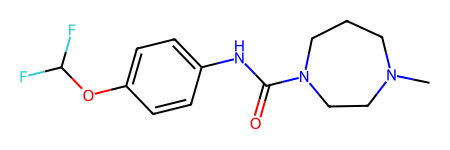

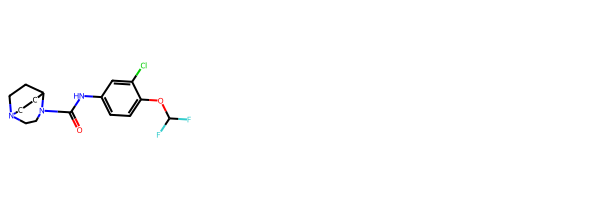

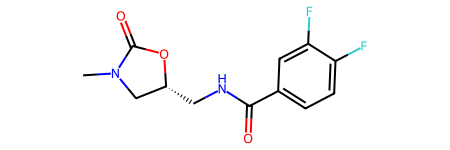

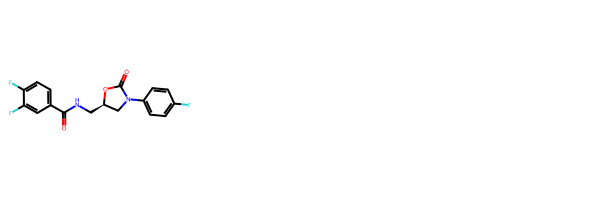

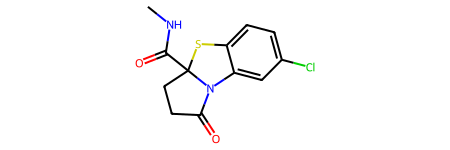

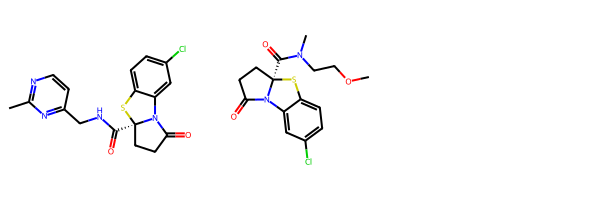

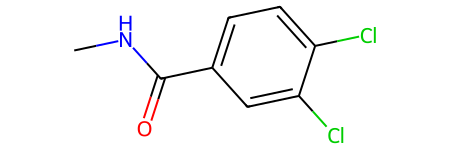

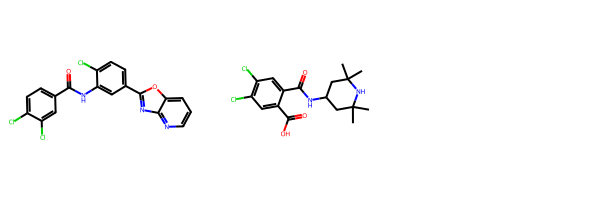

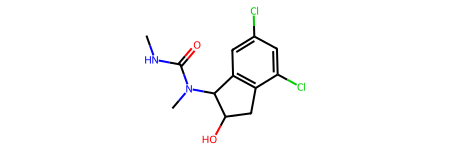

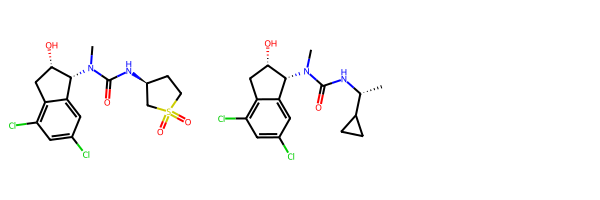

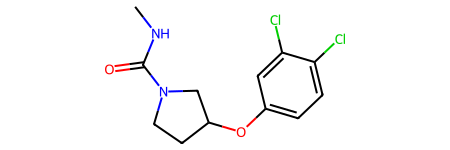

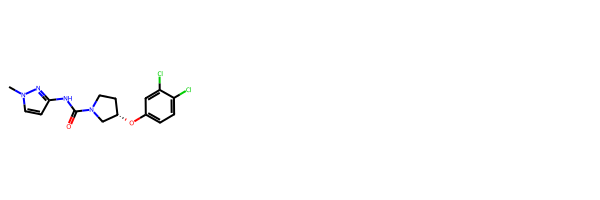

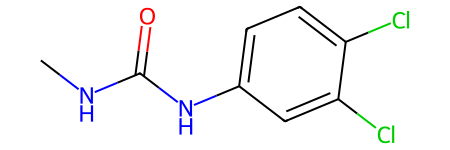

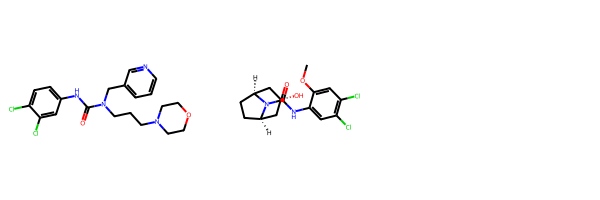

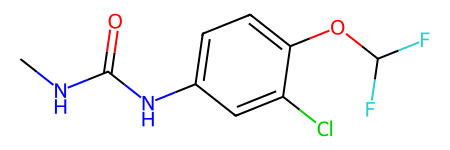

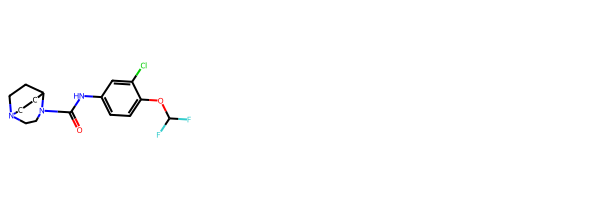

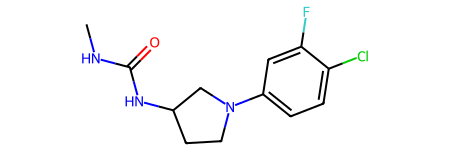

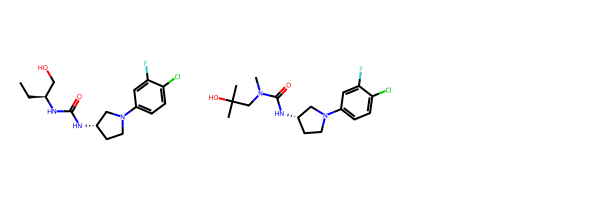

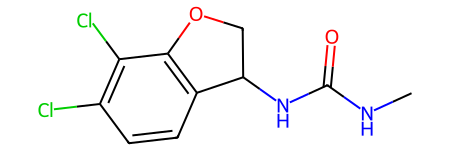

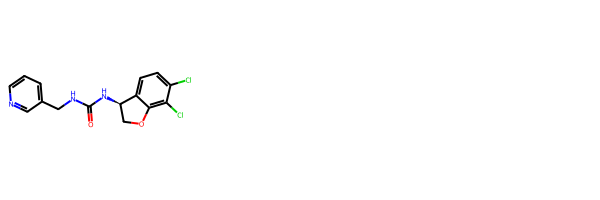

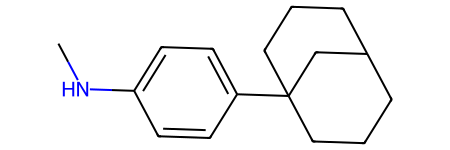

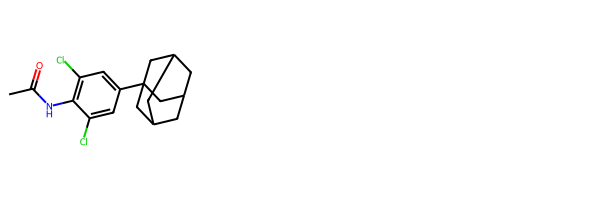

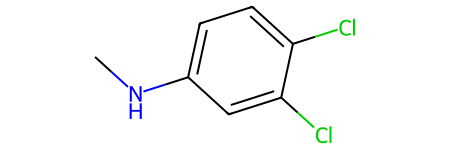

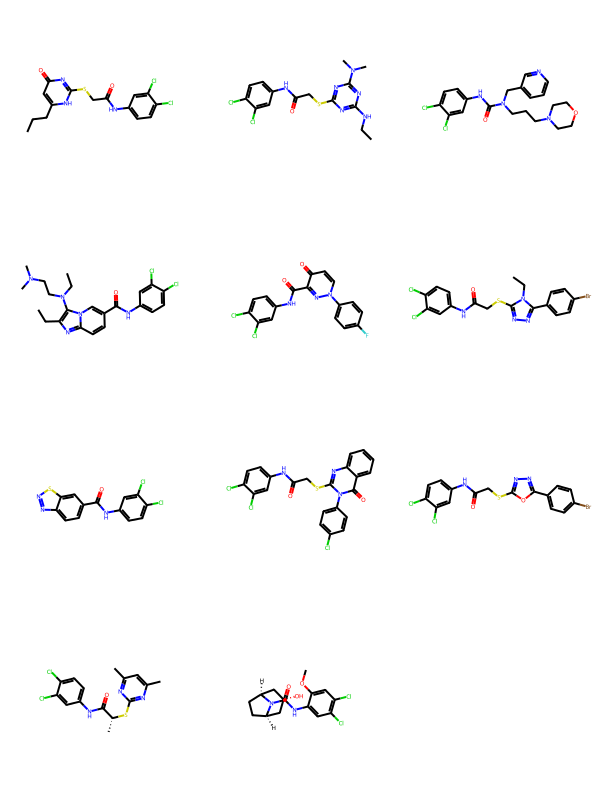

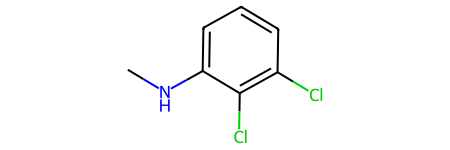

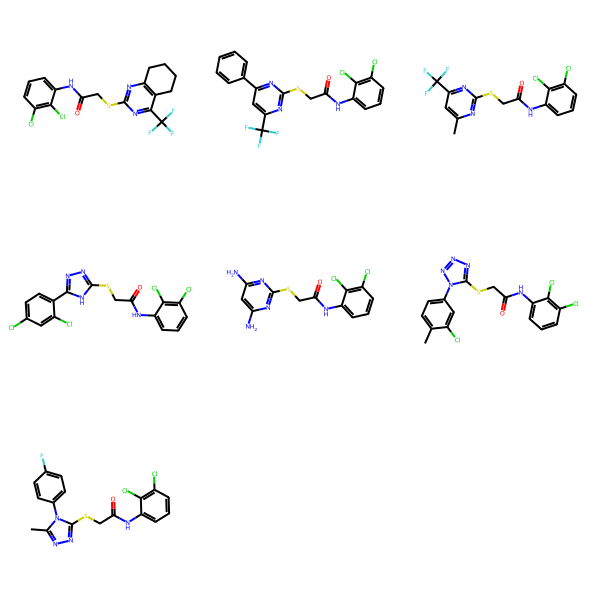

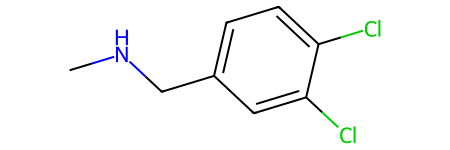

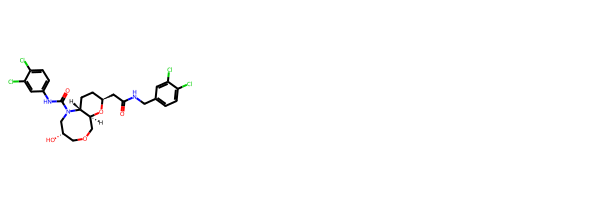

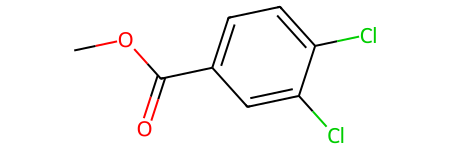

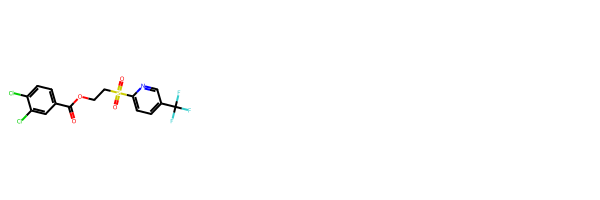

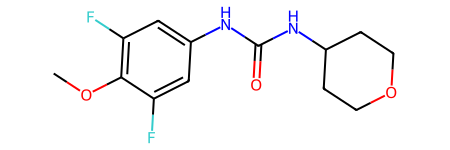

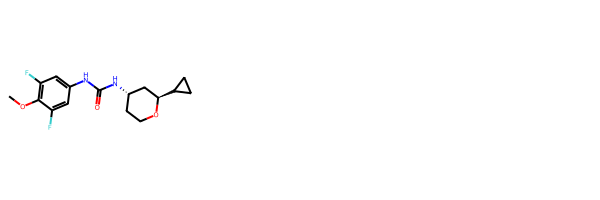

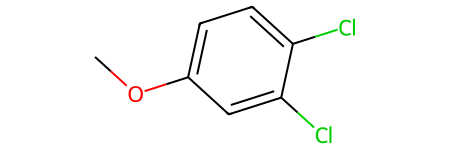

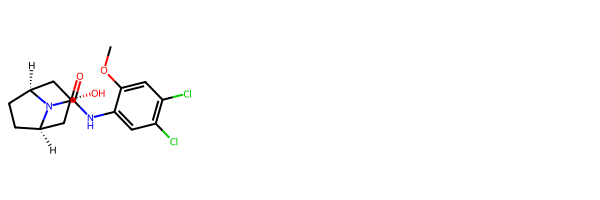

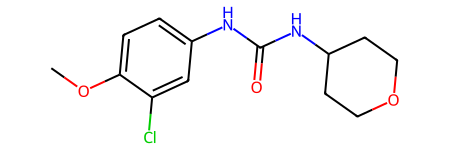

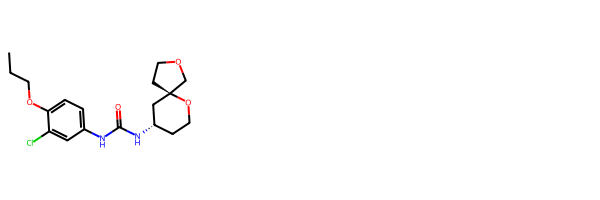

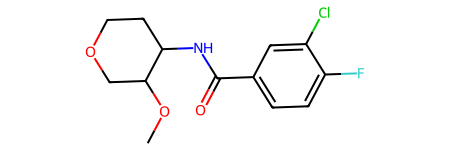

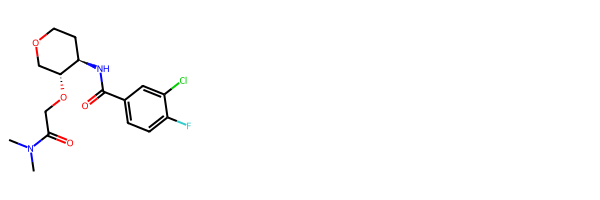

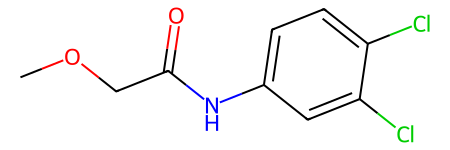

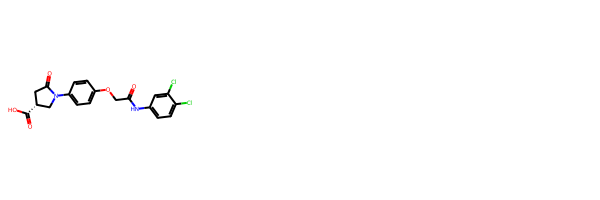

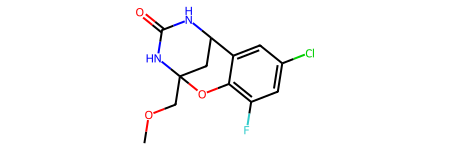

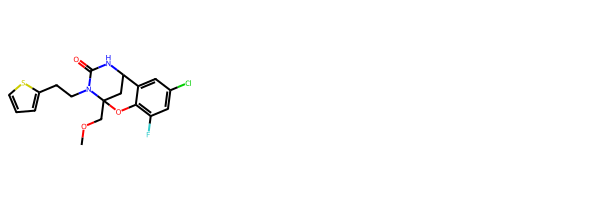

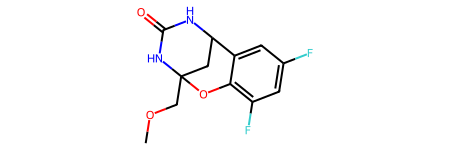

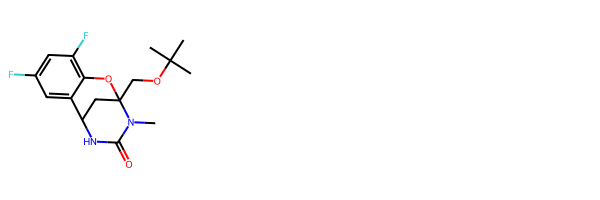

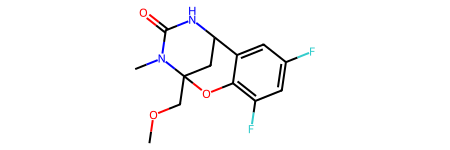

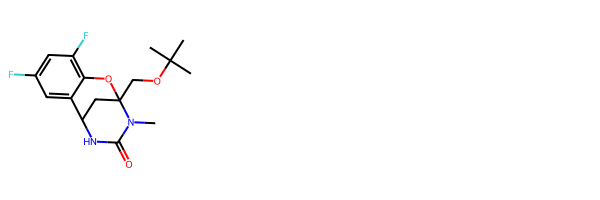

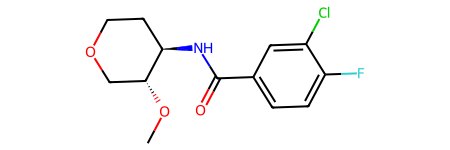

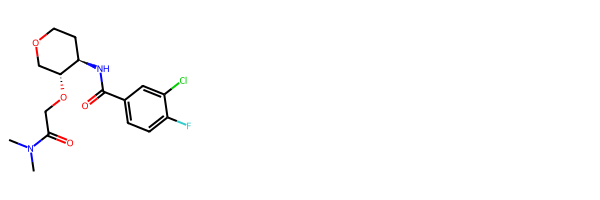

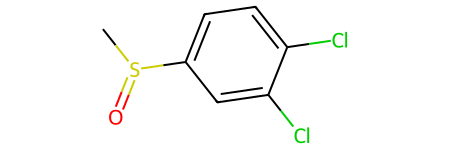

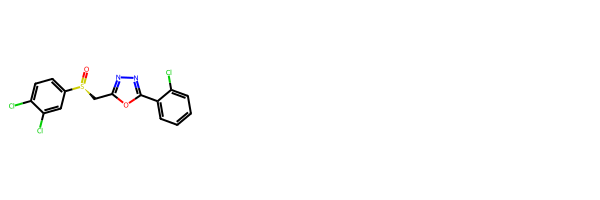

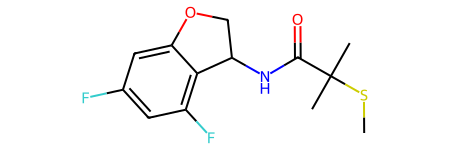

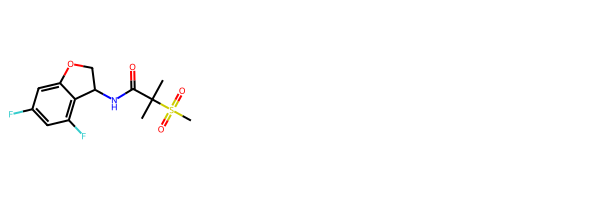

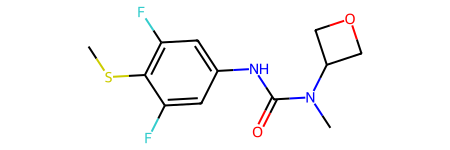

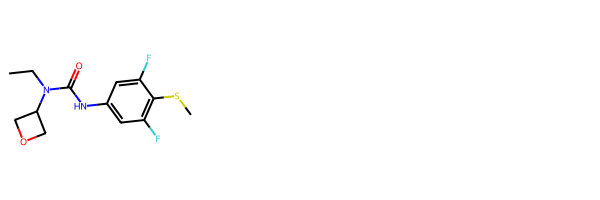

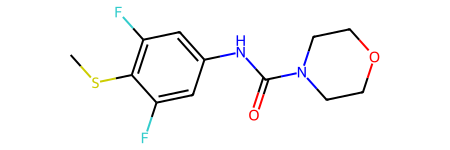

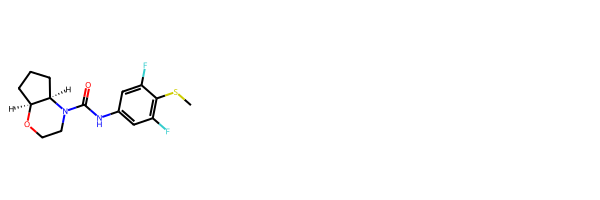

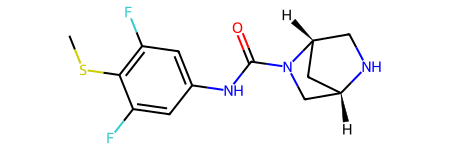

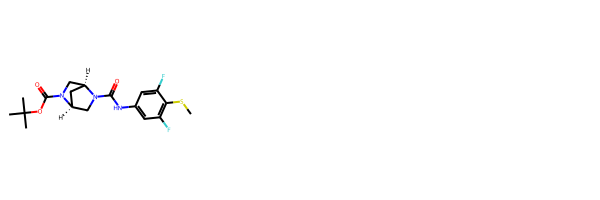

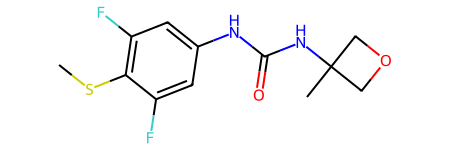

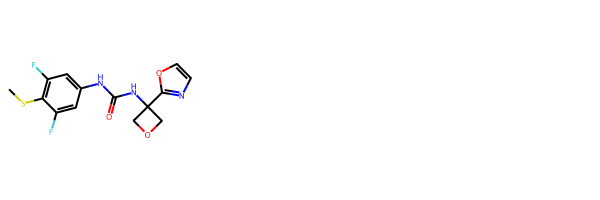

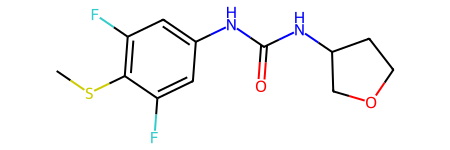

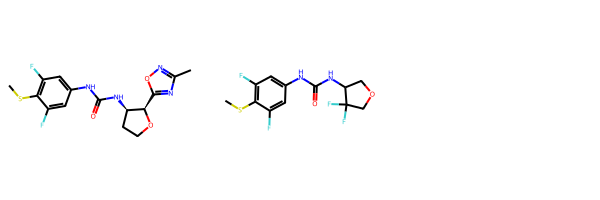

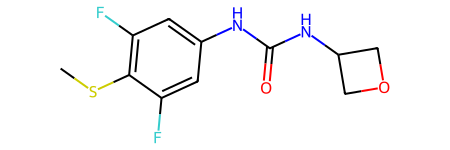

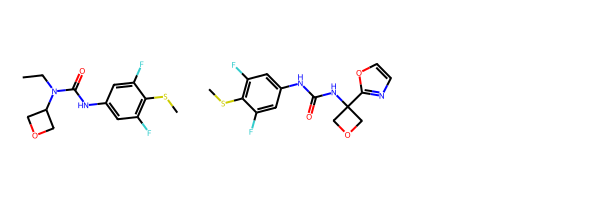

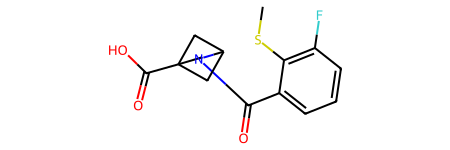

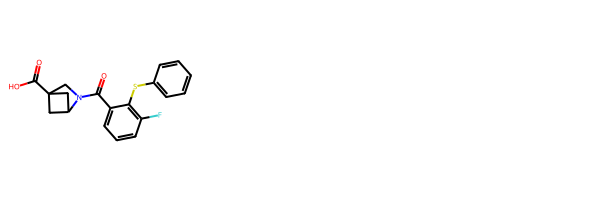

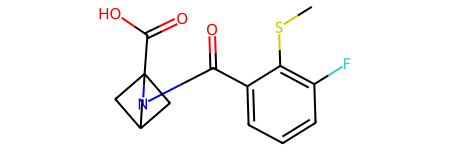

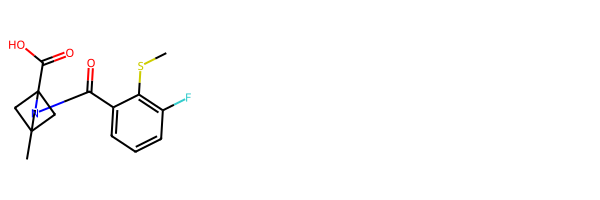

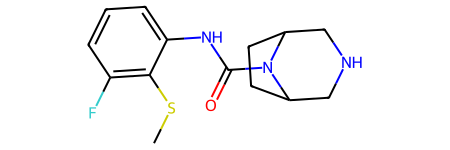

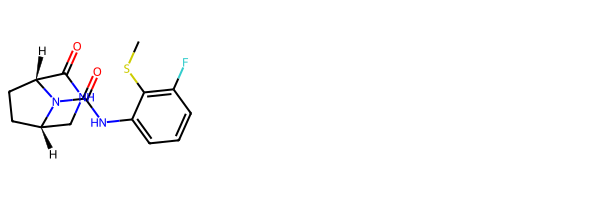

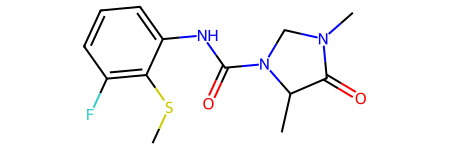

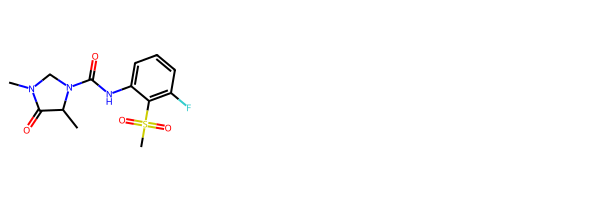

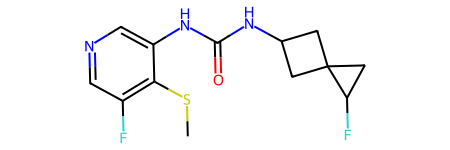

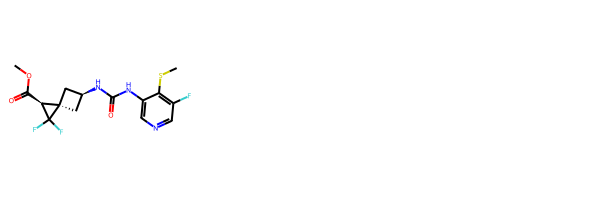

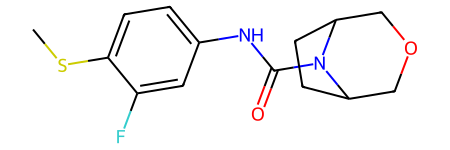

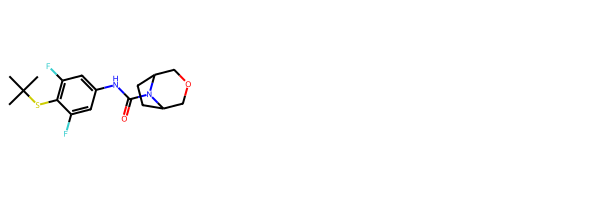

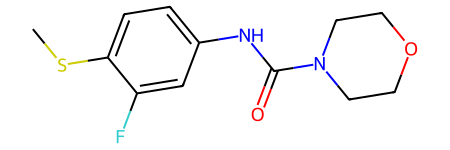

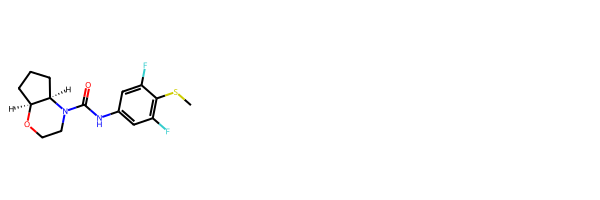

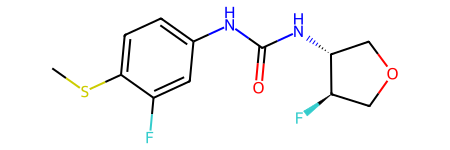

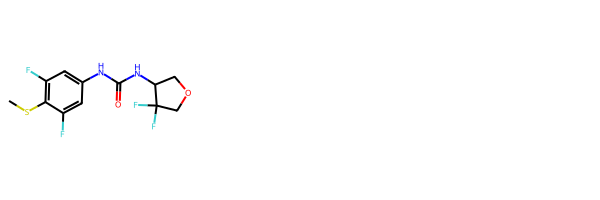

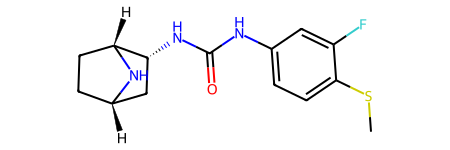

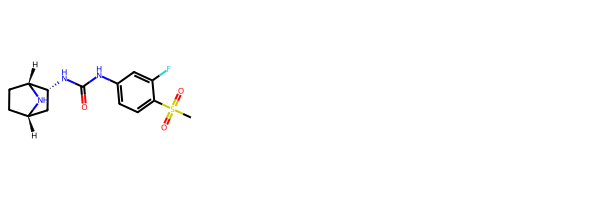

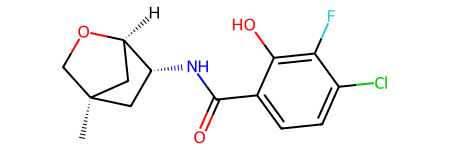

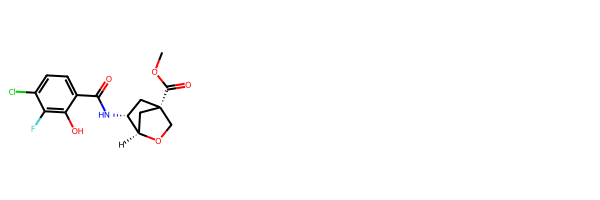

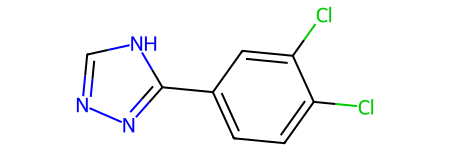

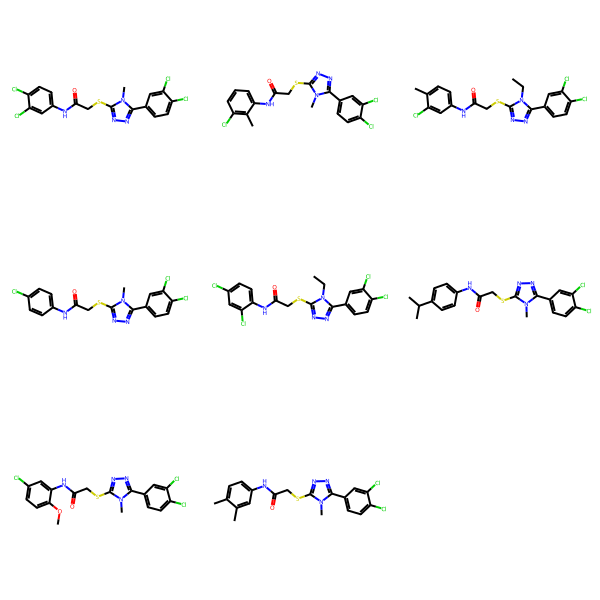

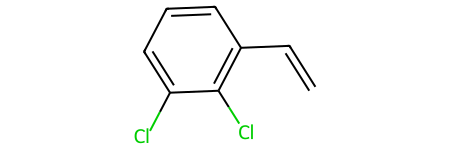

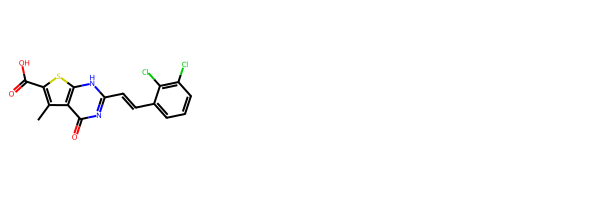

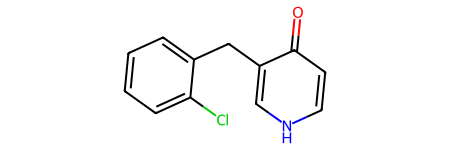

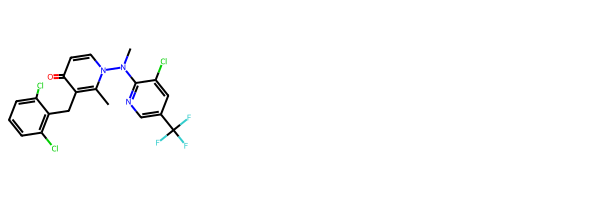

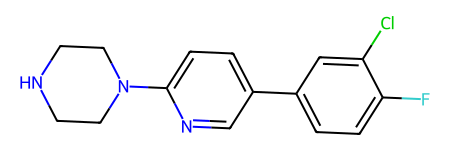

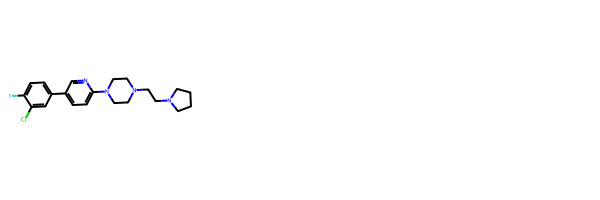

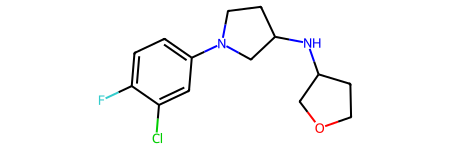

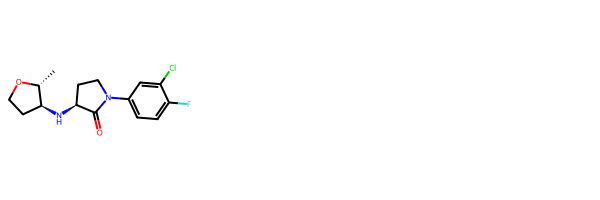

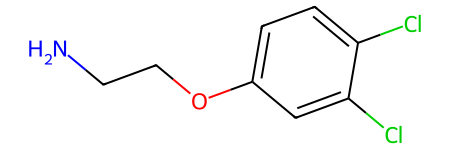

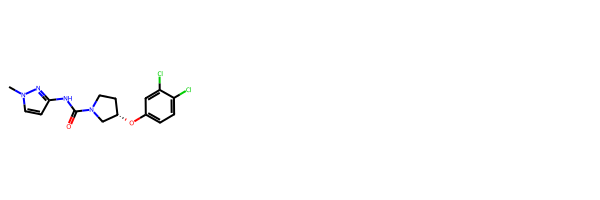

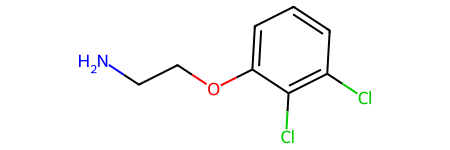

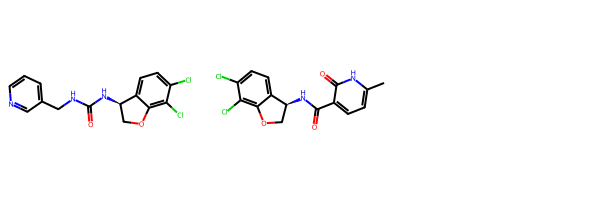

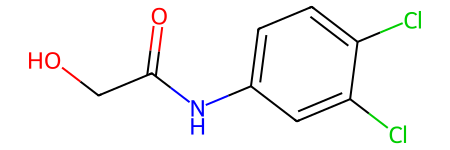

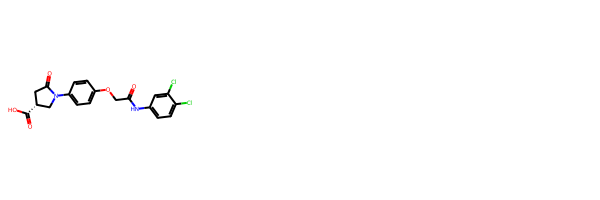

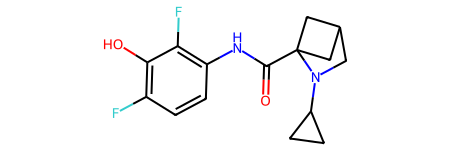

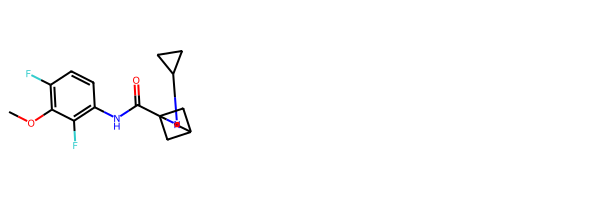

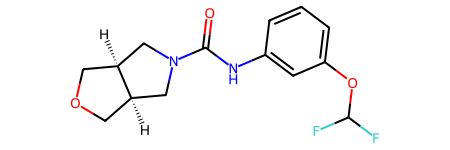

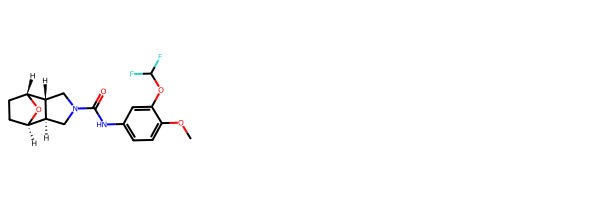

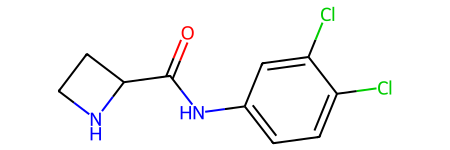

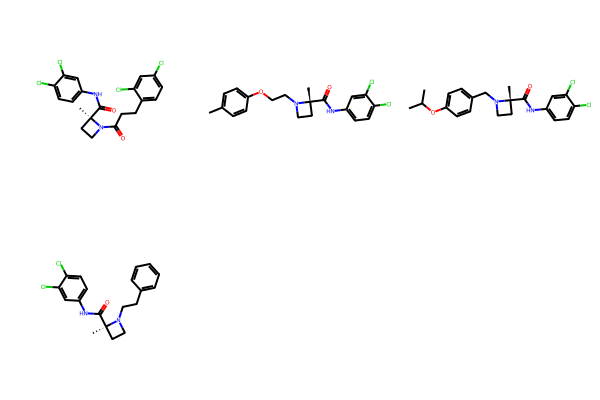

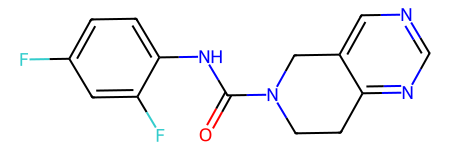

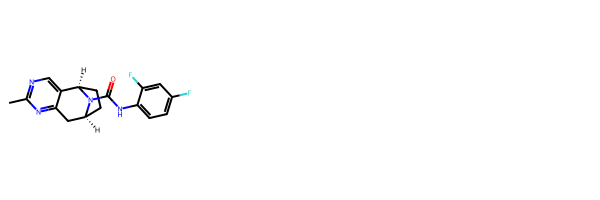

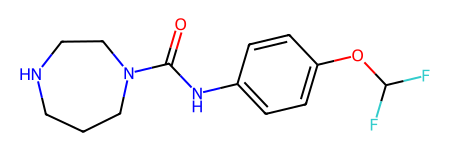

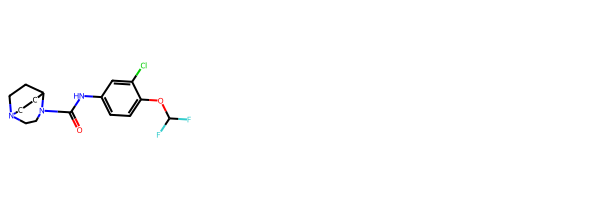

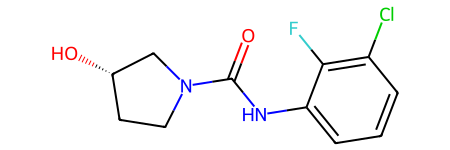

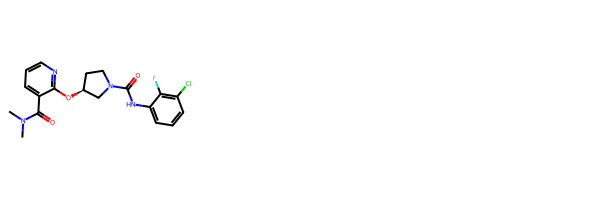

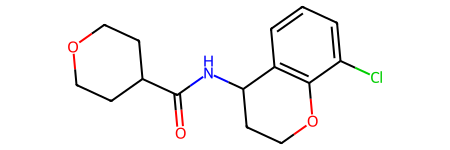

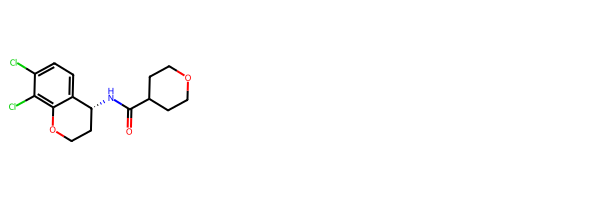

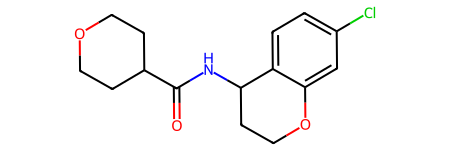

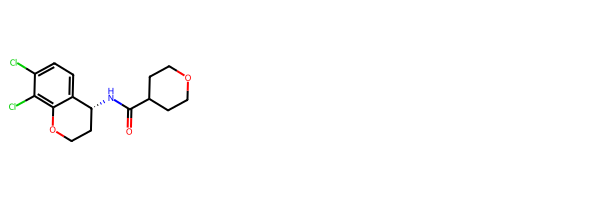

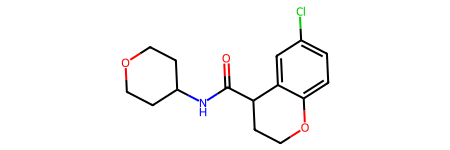

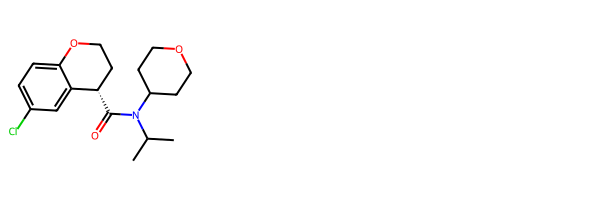

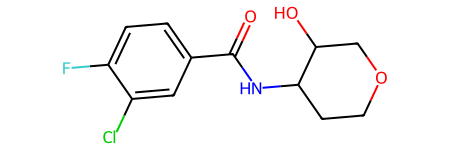

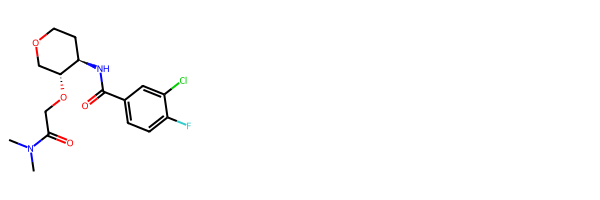

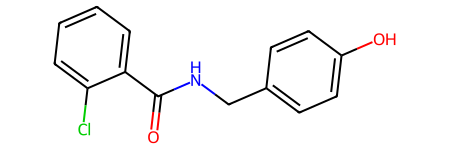

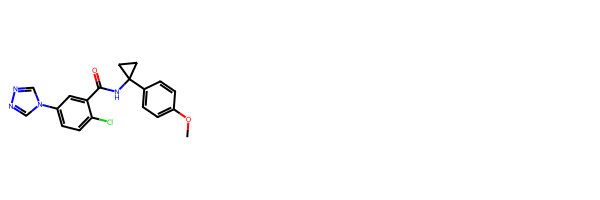

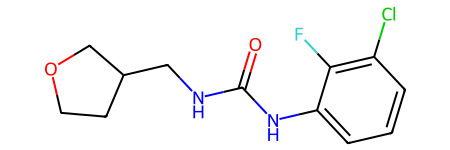

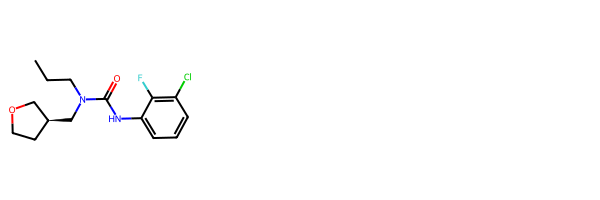

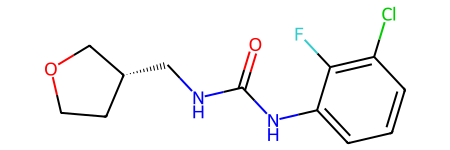

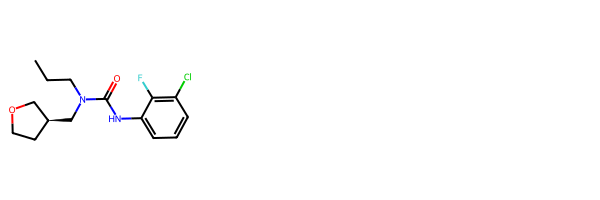

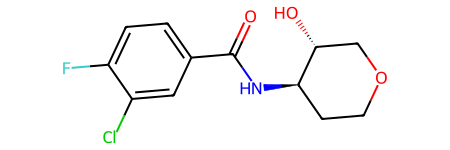

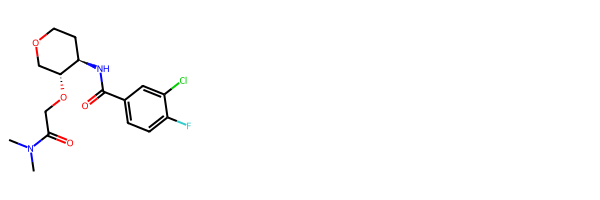

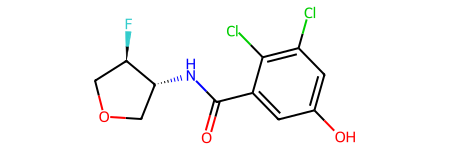

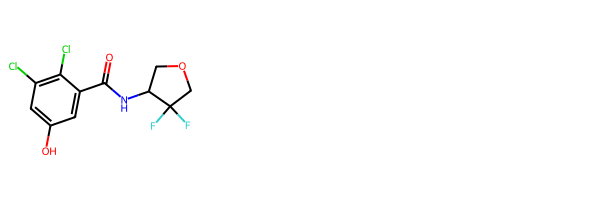

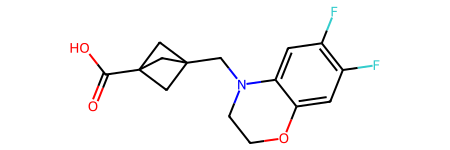

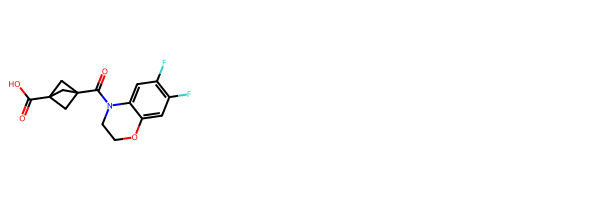

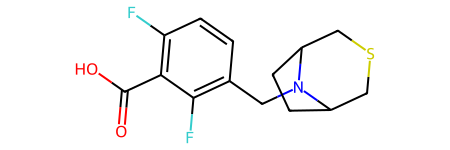

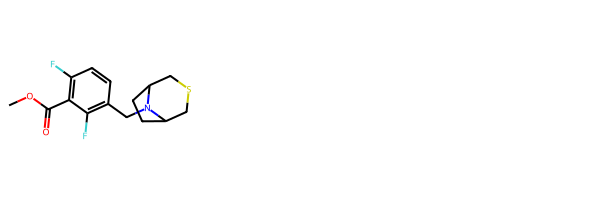

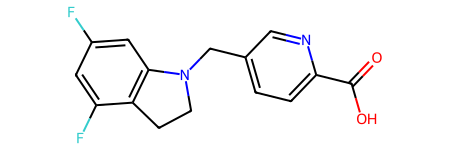

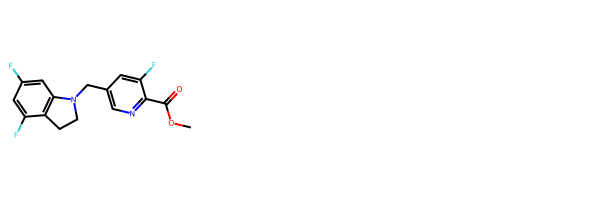

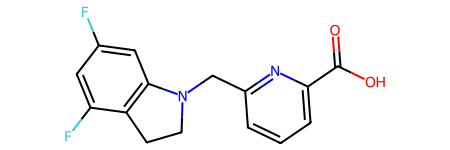

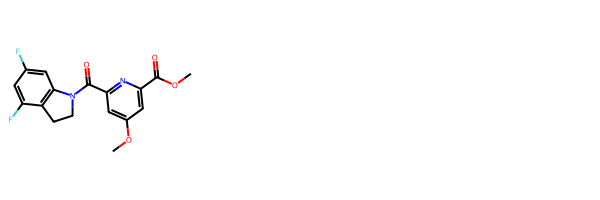

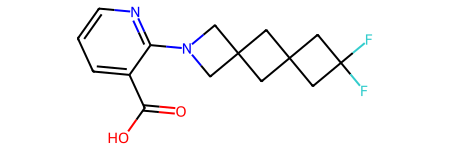

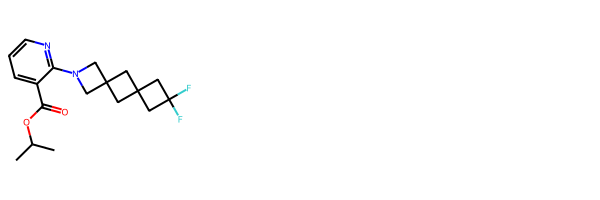

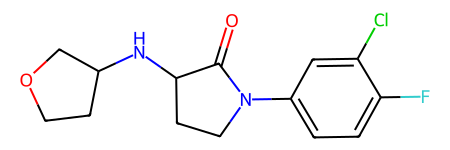

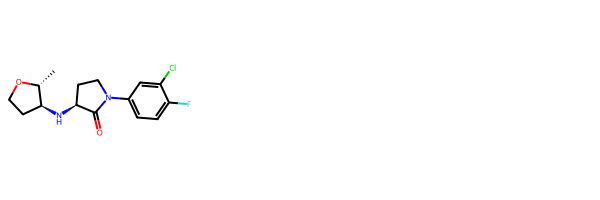

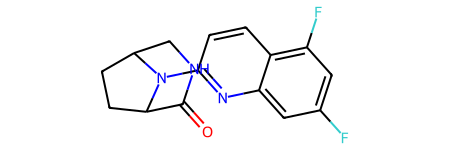

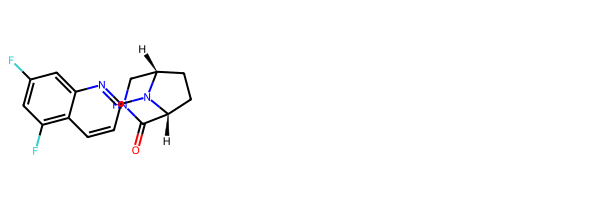

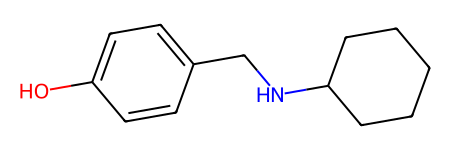

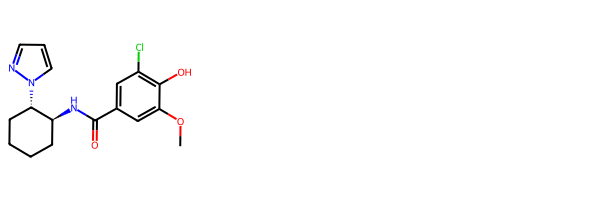

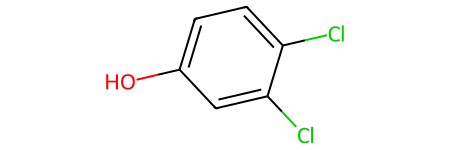

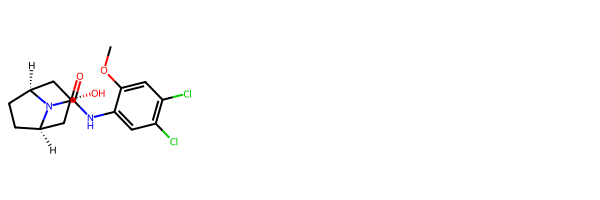

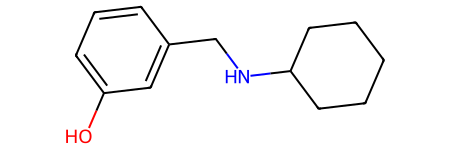

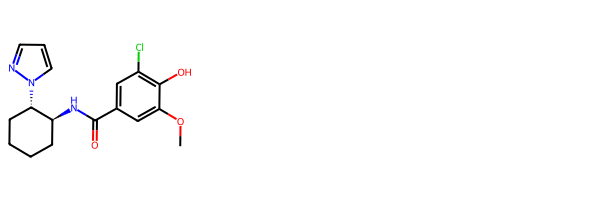

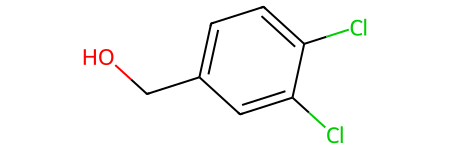

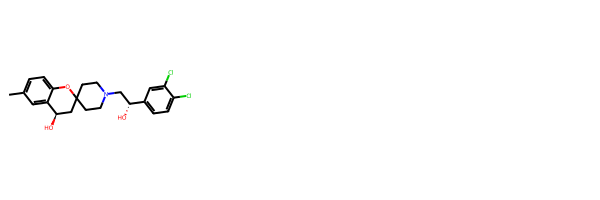

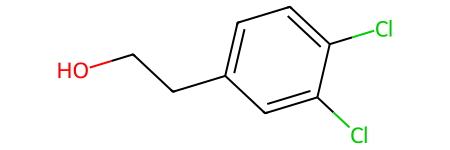

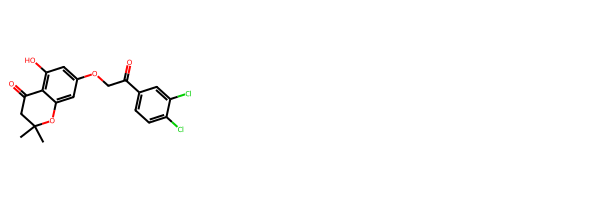

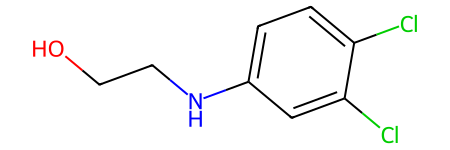

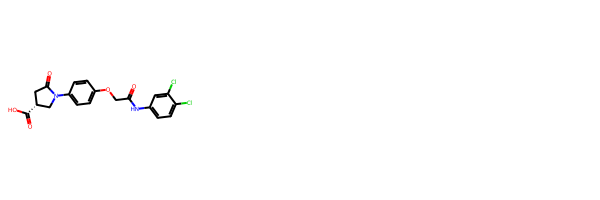

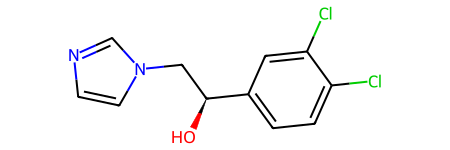

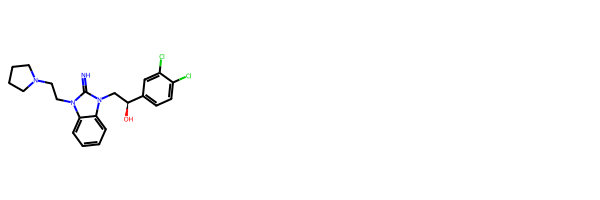

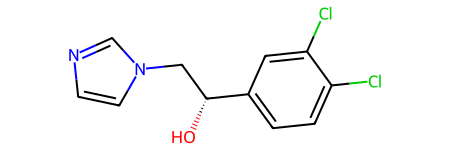

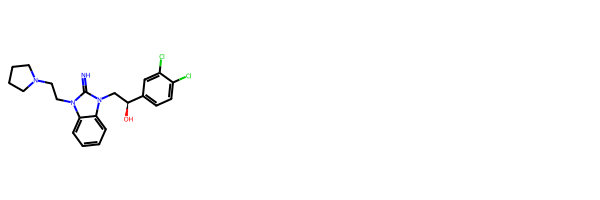

In [8]:
hit_col_dict = {'Round1-Pilot':'Confirmed-Hit', 
                'Round2-17atom':'Hit-OD',
               'Round3-Enamine': 'Confirmed-Hit',
               'Round4-Enamine Fragments+Broad': 'Hit-OD',
               'Round5-GDB11,17+Broad':'Hit-OD',
               'Round6-Enamine_frags_no_cpd': 'Confirmed-Hit'}

# despite the name this is actually hits1 thru 6 (rd1 - rd6)
hits1thru5, nonhits1thru5 = preprocess_df_sort_according_to_hit(fulldf, hit_col_dict)
path = '../figs/intermediate_data/fragments/rd1thru6/'
plot_fragments_within_cpd_groups(hits1thru5, name_col = 'Name', file_name_col = 'fragment_name', path = path)
plot_fragments_within_cpd_groups(nonhits1thru5, name_col = 'Name', file_name_col = 'fragment_name', path = path + 'nonhit_')


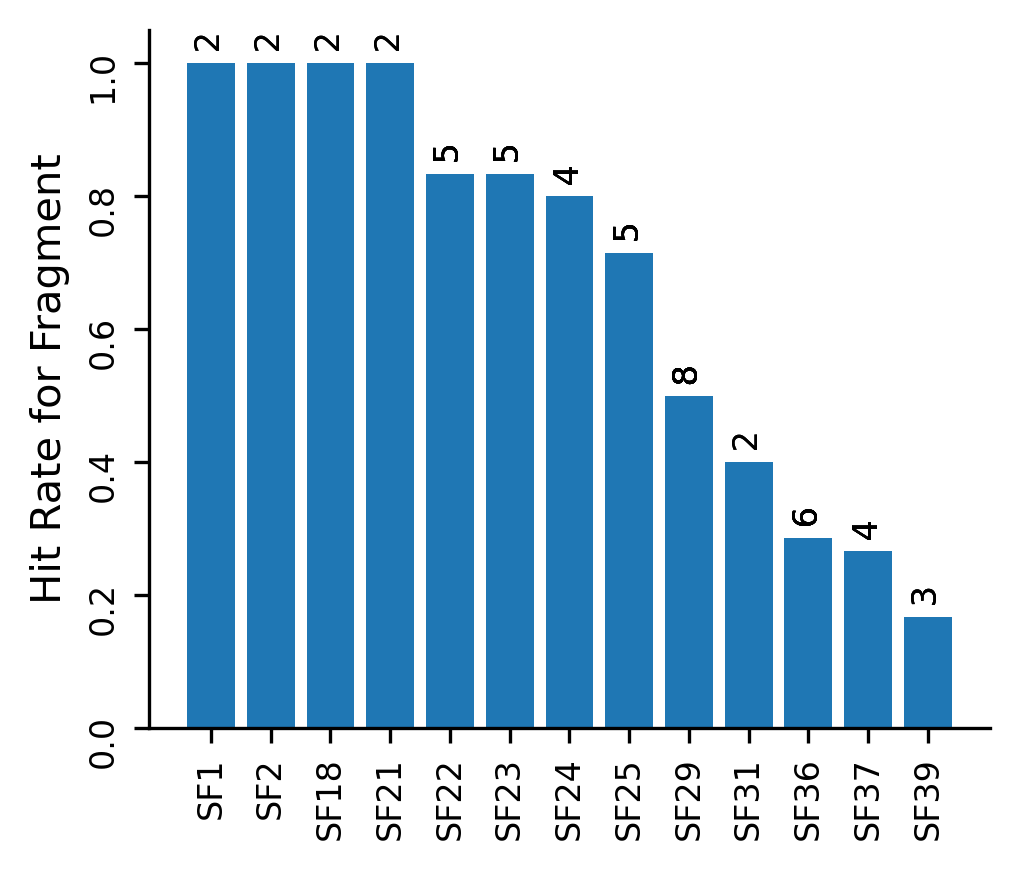

In [9]:
plot_fragment_hit_rates(hits1thru5, '../figs/figure_panels/successful_sa_frags')

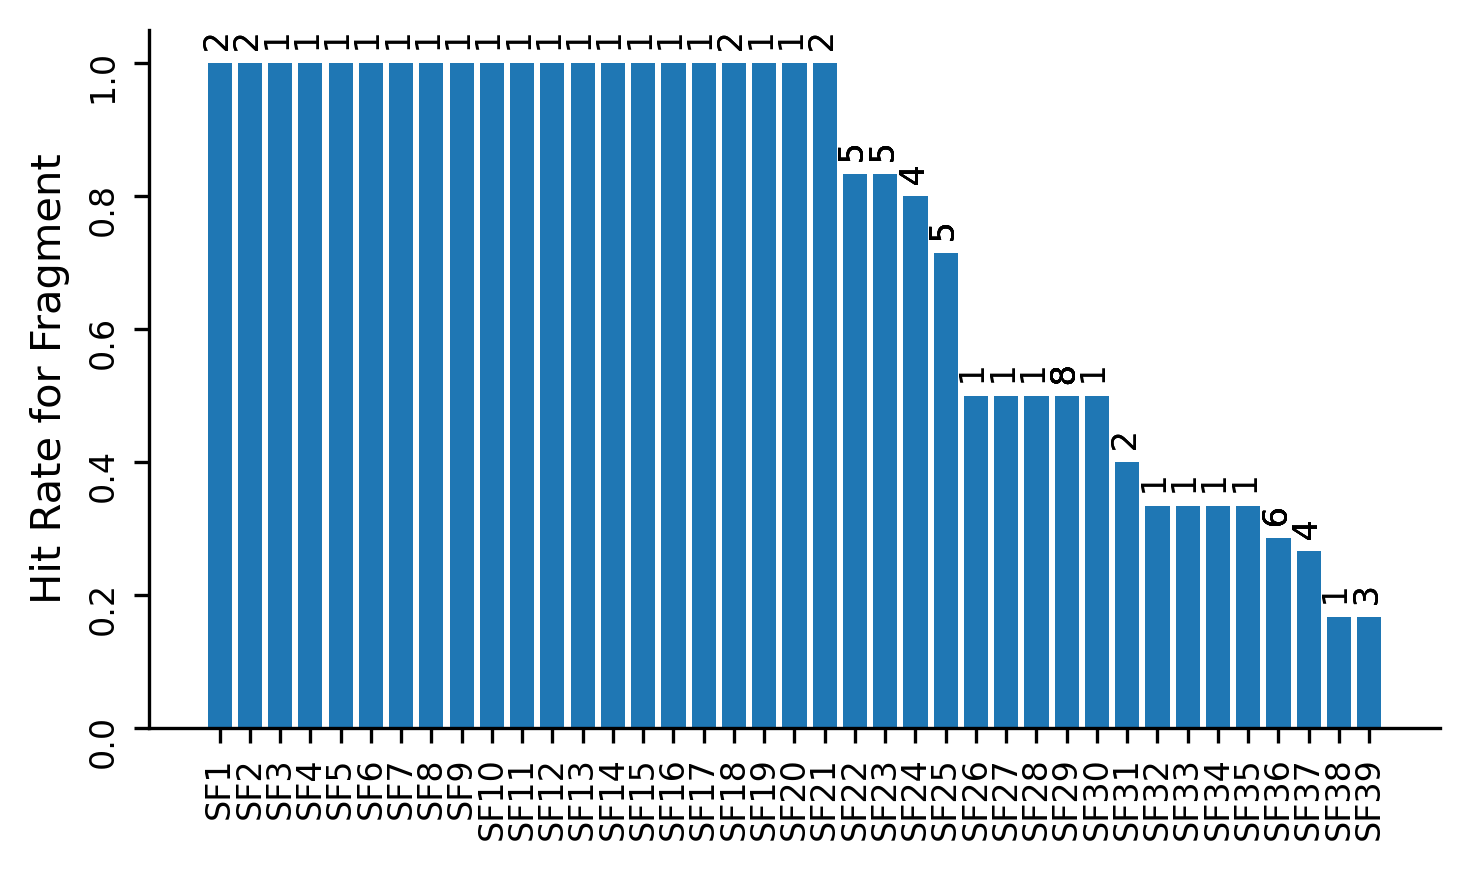

In [10]:
plot_fragment_hit_rates(hits1thru5, '../figs/figure_panels/successful_sa_frags_all', threshold_above_1 = False, fig_size = (5, 3))

# Round 1 for NG frags

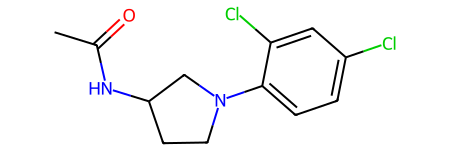

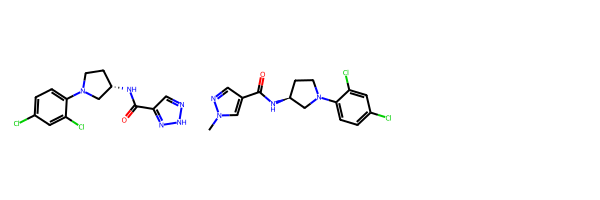

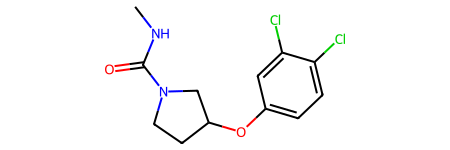

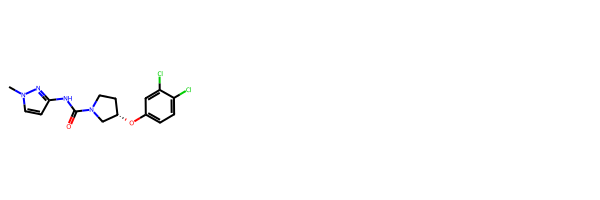

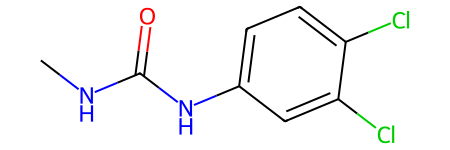

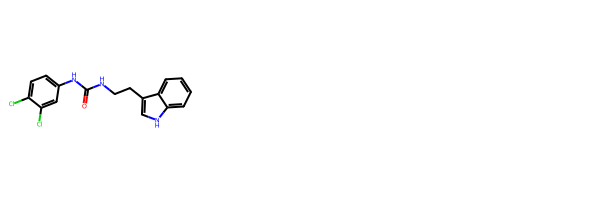

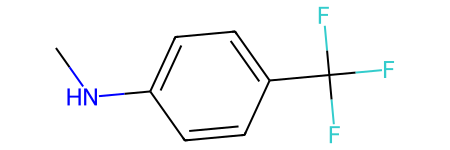

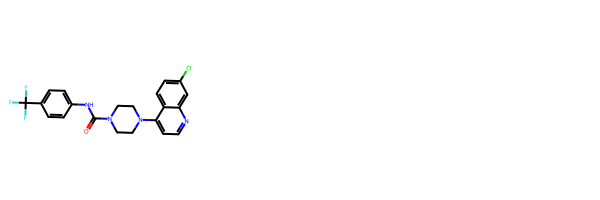

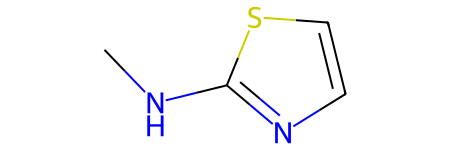

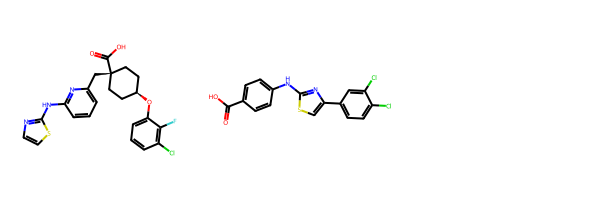

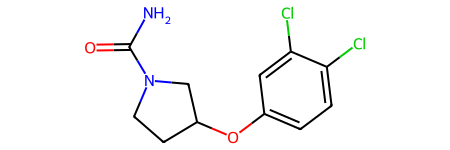

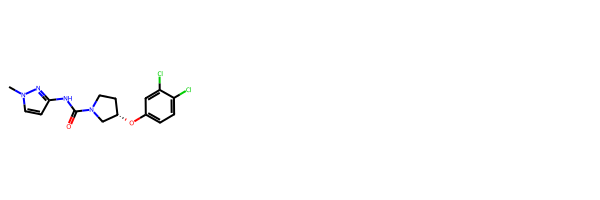

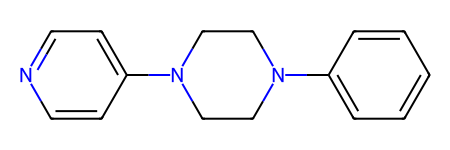

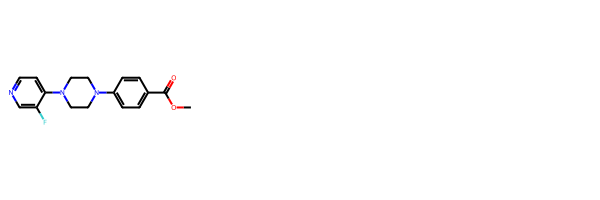

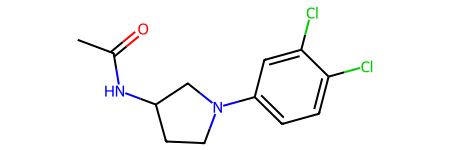

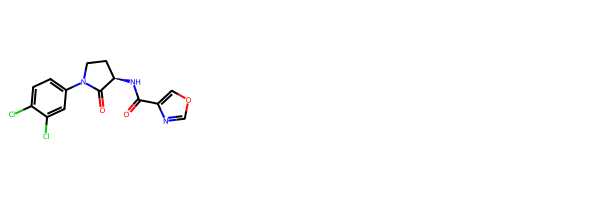

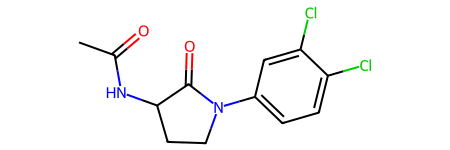

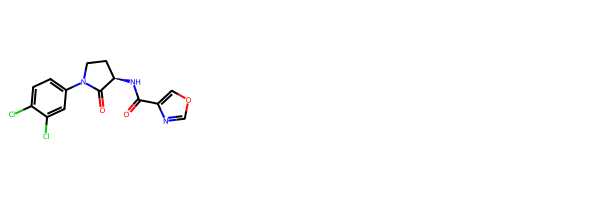

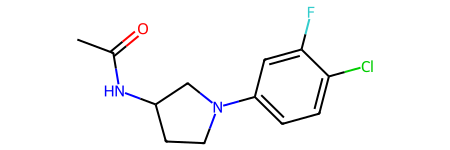

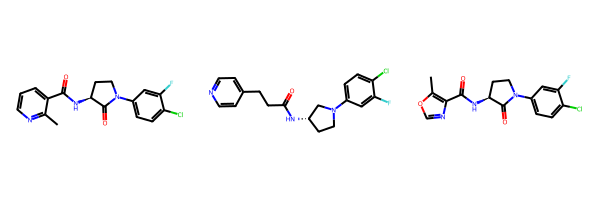

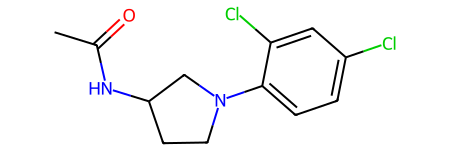

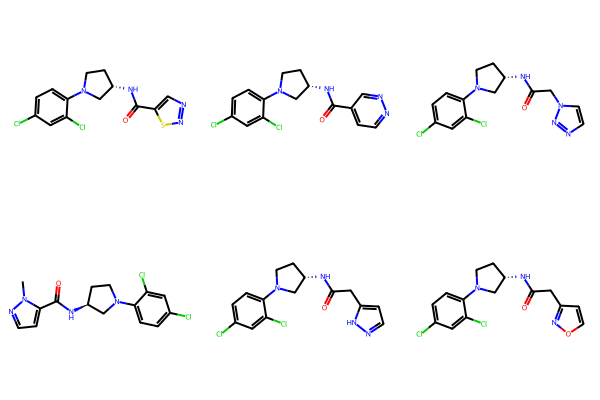

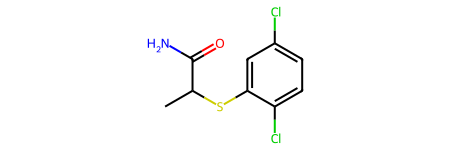

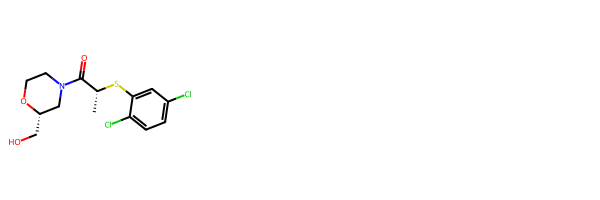

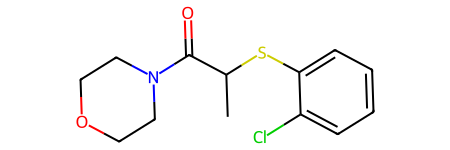

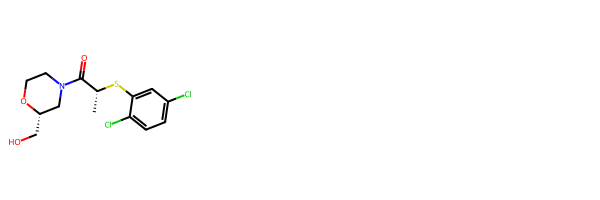

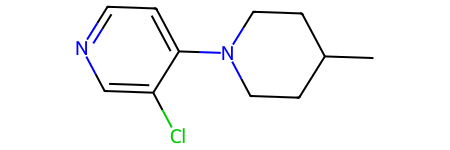

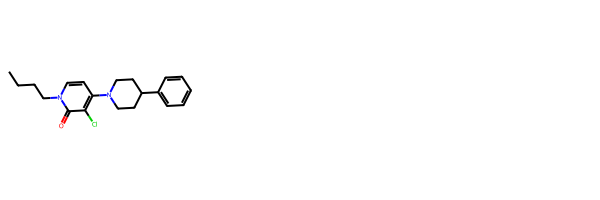

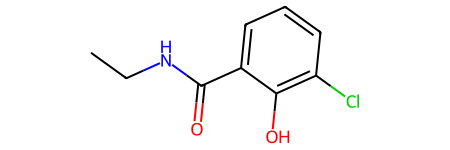

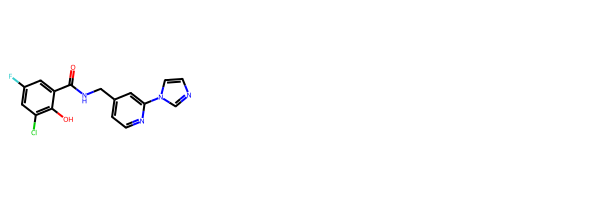

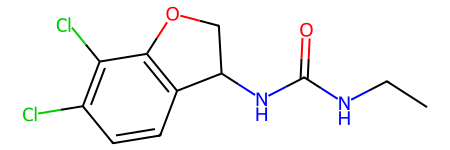

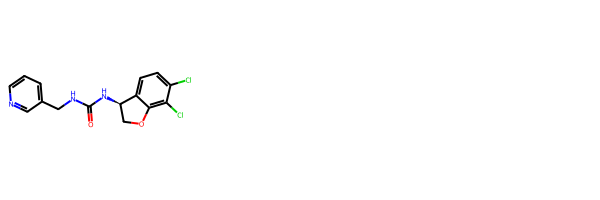

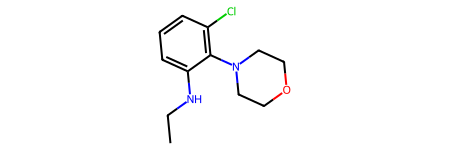

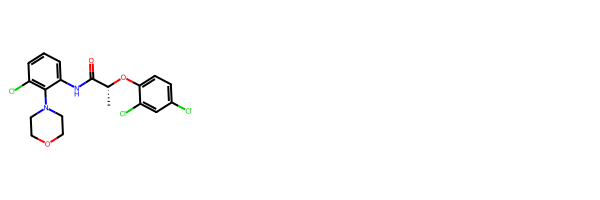

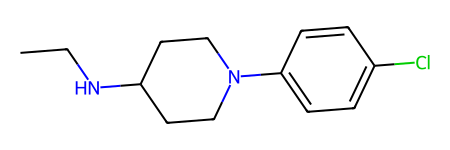

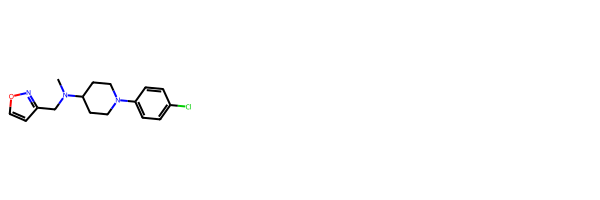

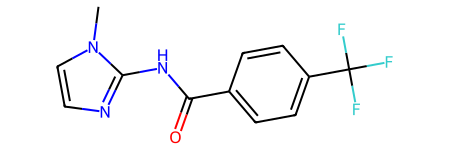

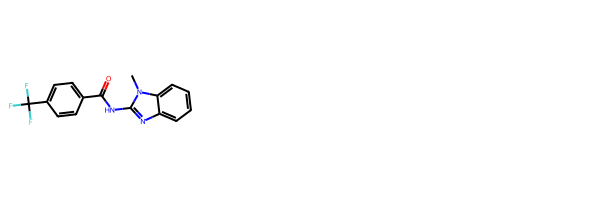

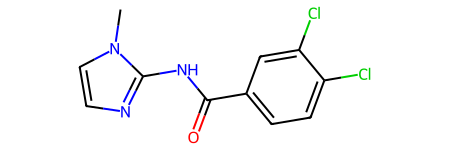

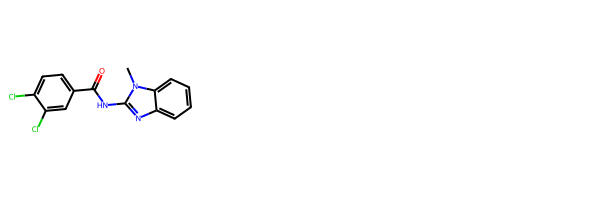

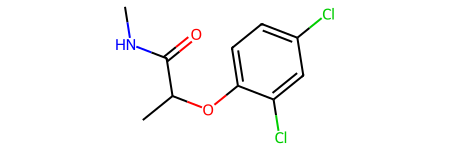

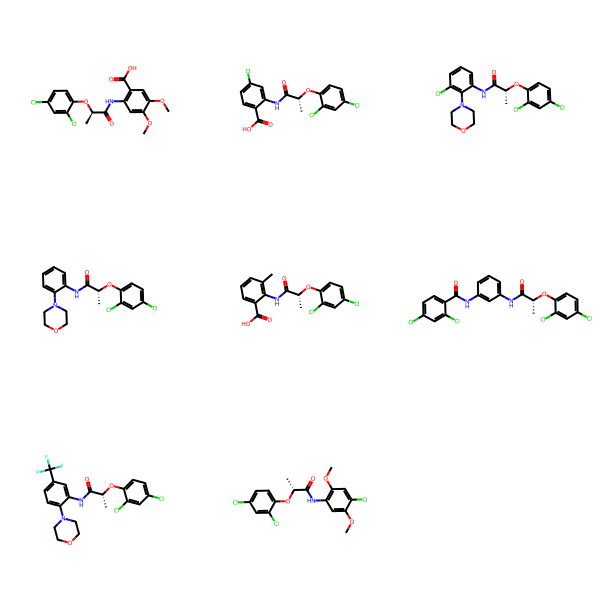

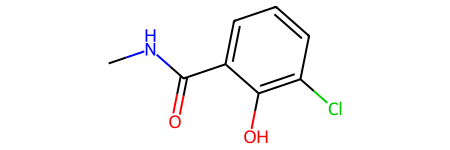

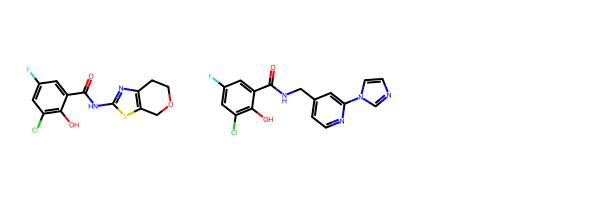

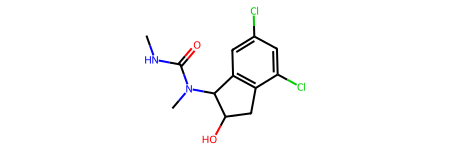

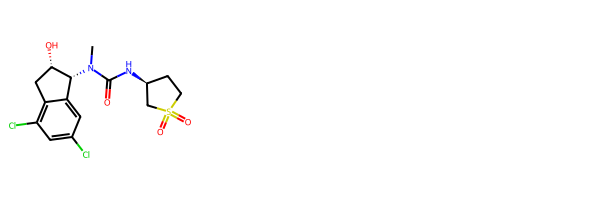

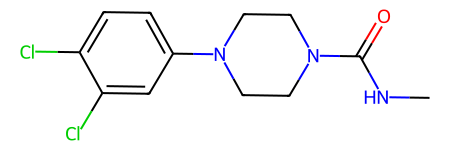

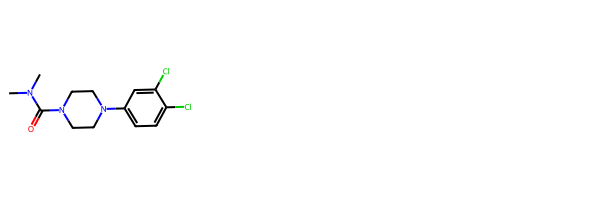

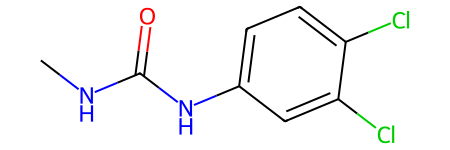

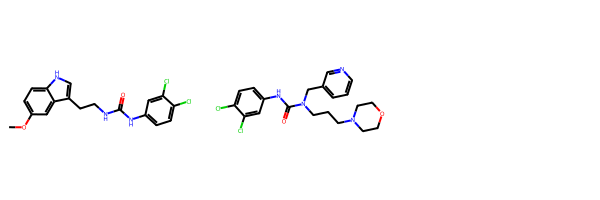

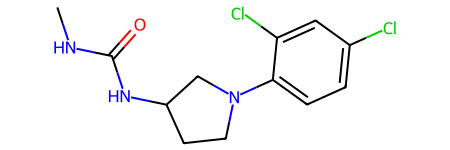

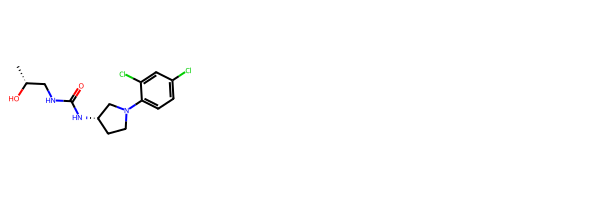

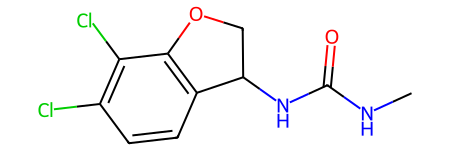

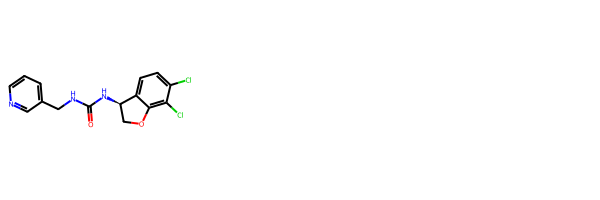

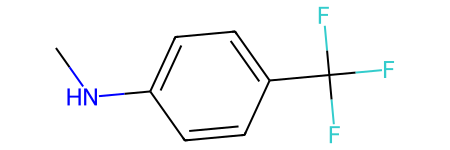

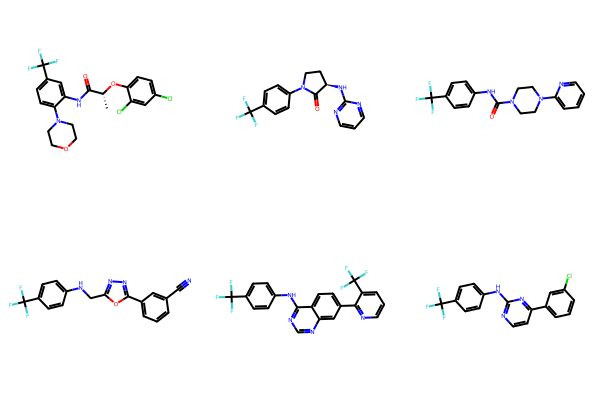

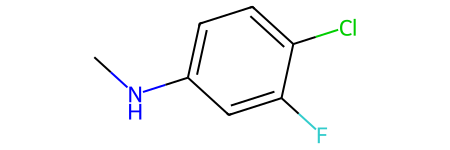

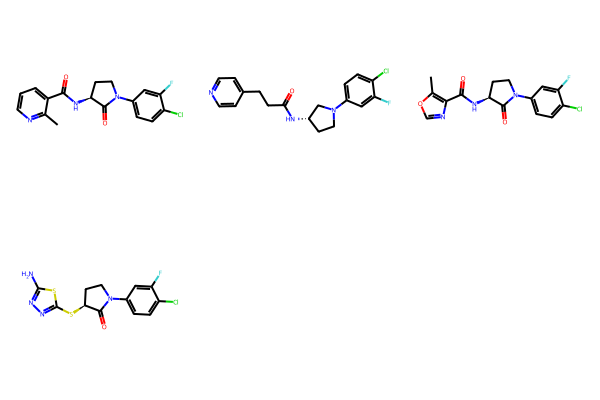

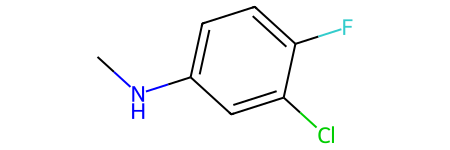

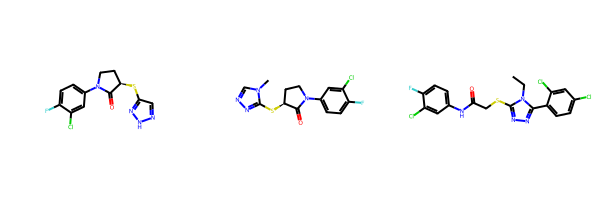

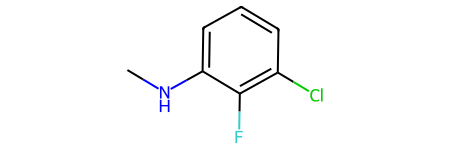

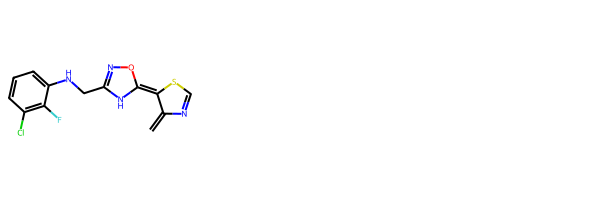

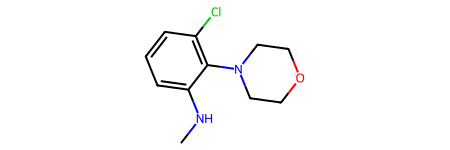

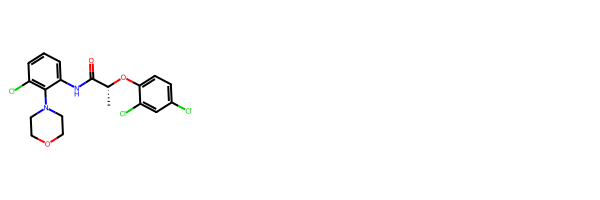

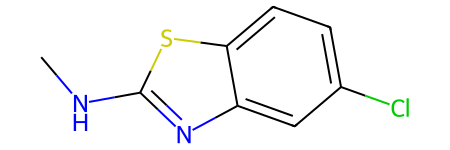

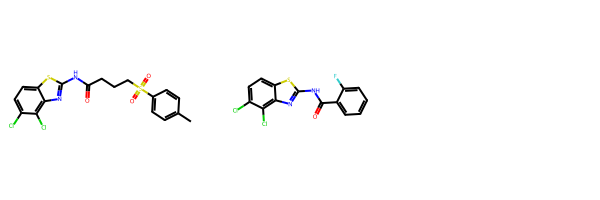

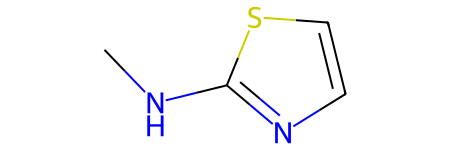

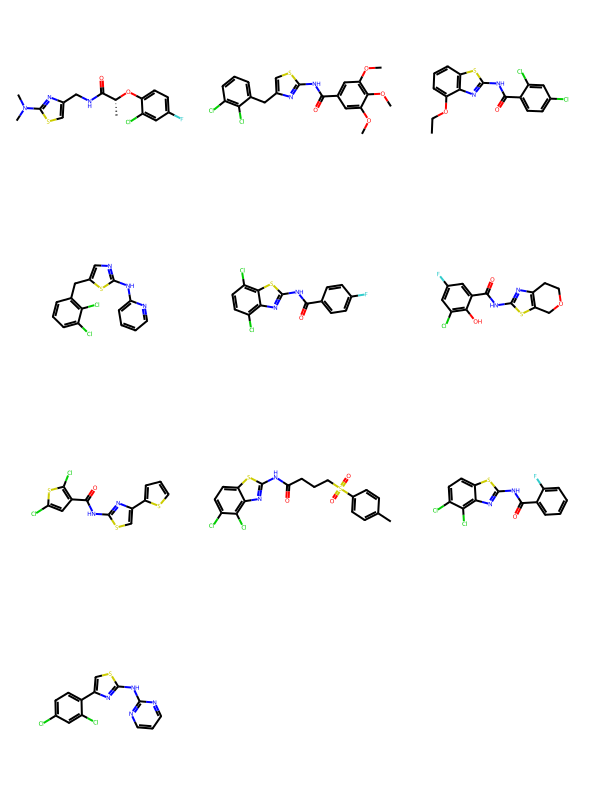

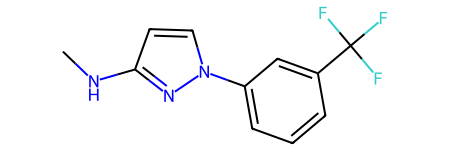

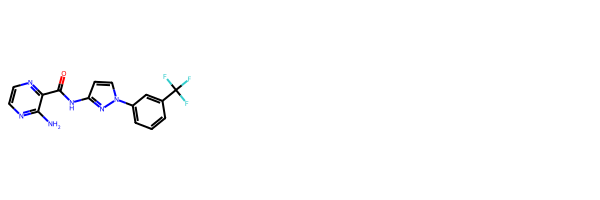

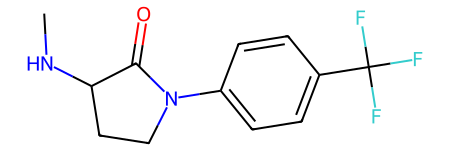

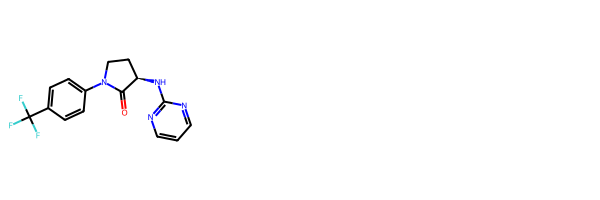

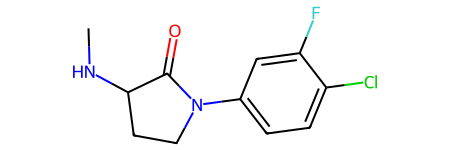

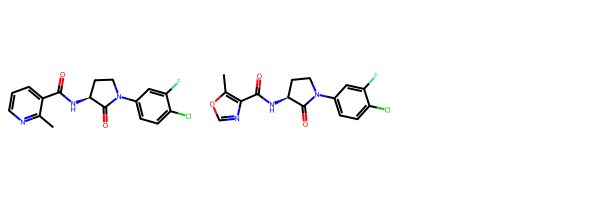

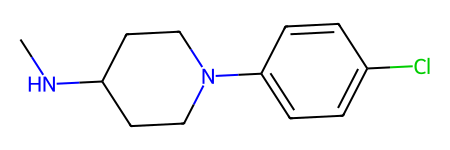

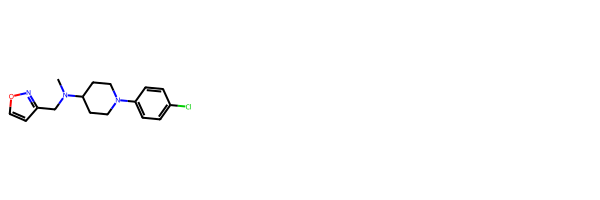

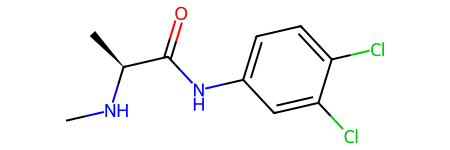

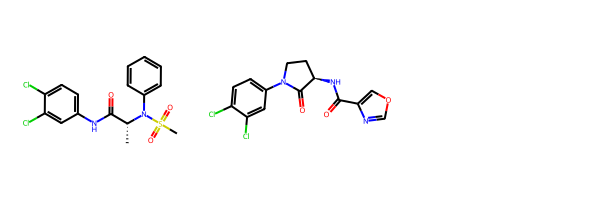

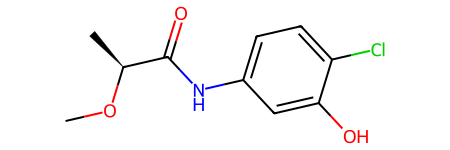

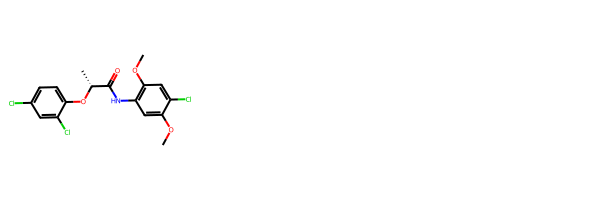

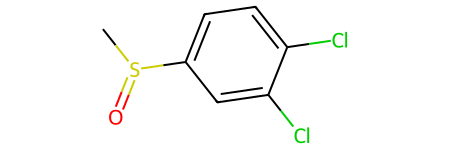

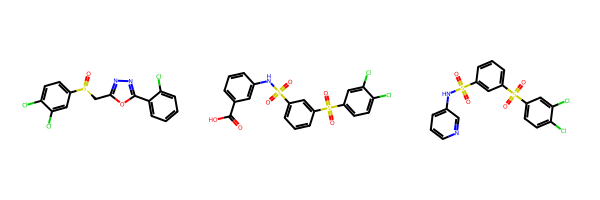

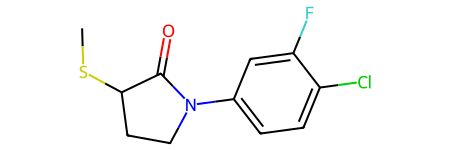

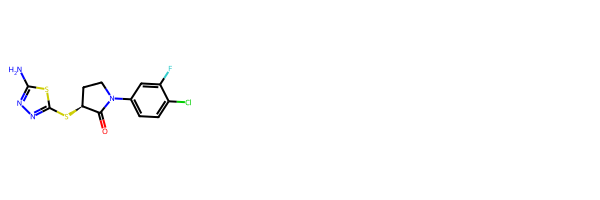

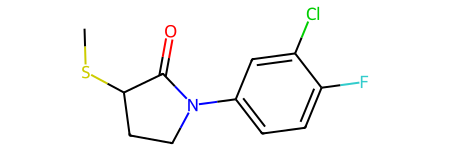

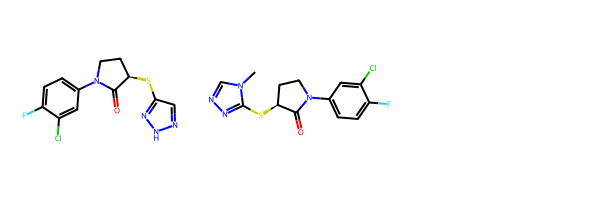

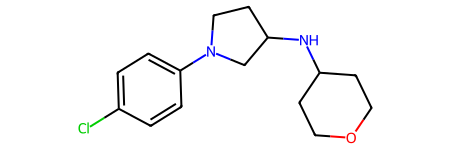

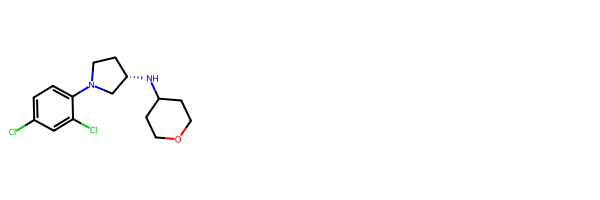

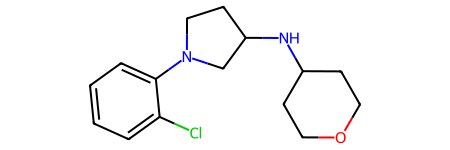

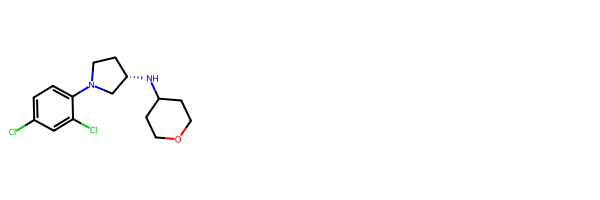

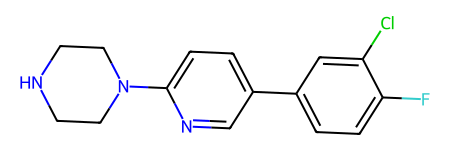

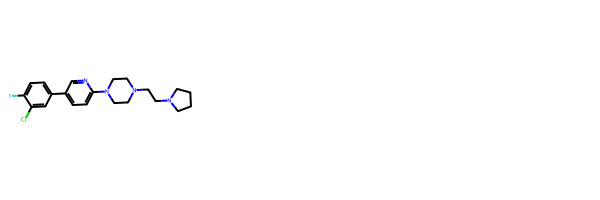

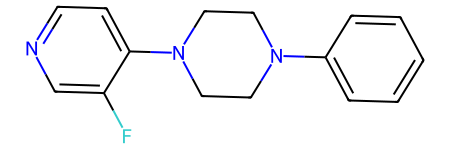

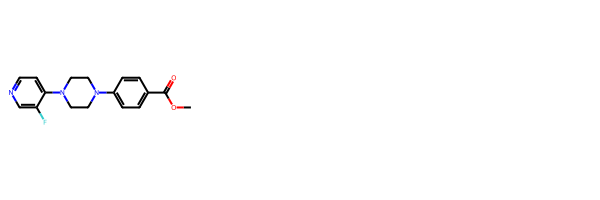

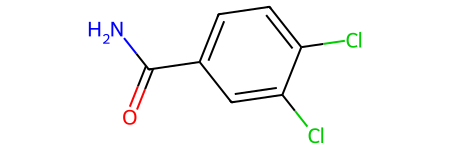

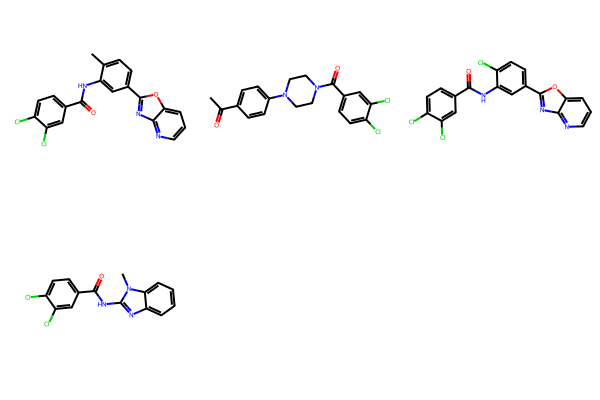

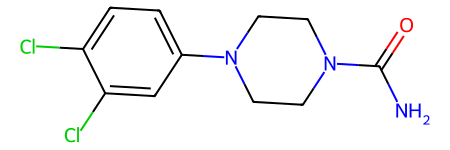

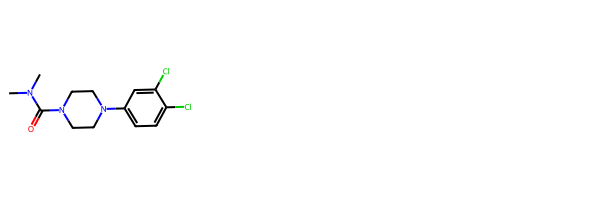

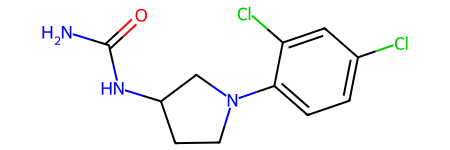

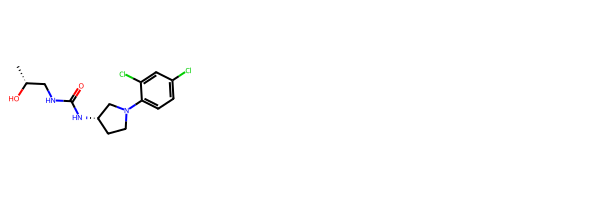

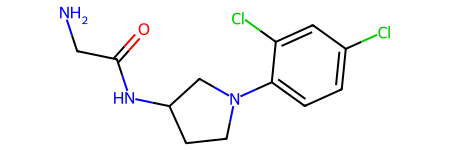

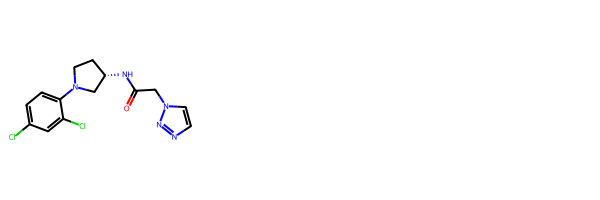

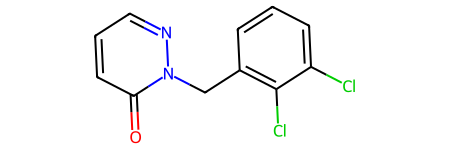

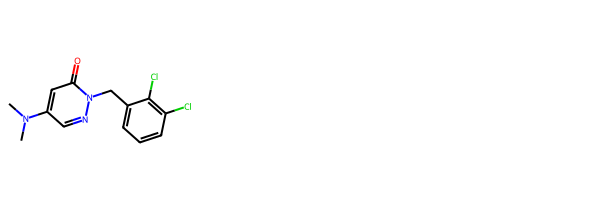

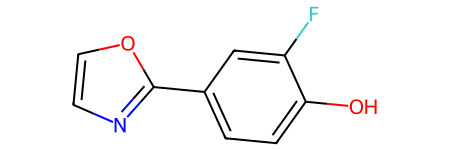

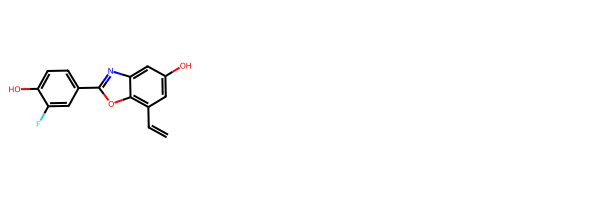

In [11]:
rd1ng = pd.read_csv('../out/melis_fragments_metadata_round1.csv')
hit_col_dict = {'Round1-NG':'hit'}

hits, nonhits = preprocess_df_sort_according_to_hit(rd1ng, hit_col_dict, frag_prefix = 'NF')
path = '../figs/intermediate_data/fragments/ngrd1/'
plot_fragments_within_cpd_groups(hits, name_col = 'Name', file_name_col = 'fragment_name', path = path)
plot_fragments_within_cpd_groups(nonhits, name_col = 'Name', file_name_col = 'fragment_name', path = path + 'nonhit_')

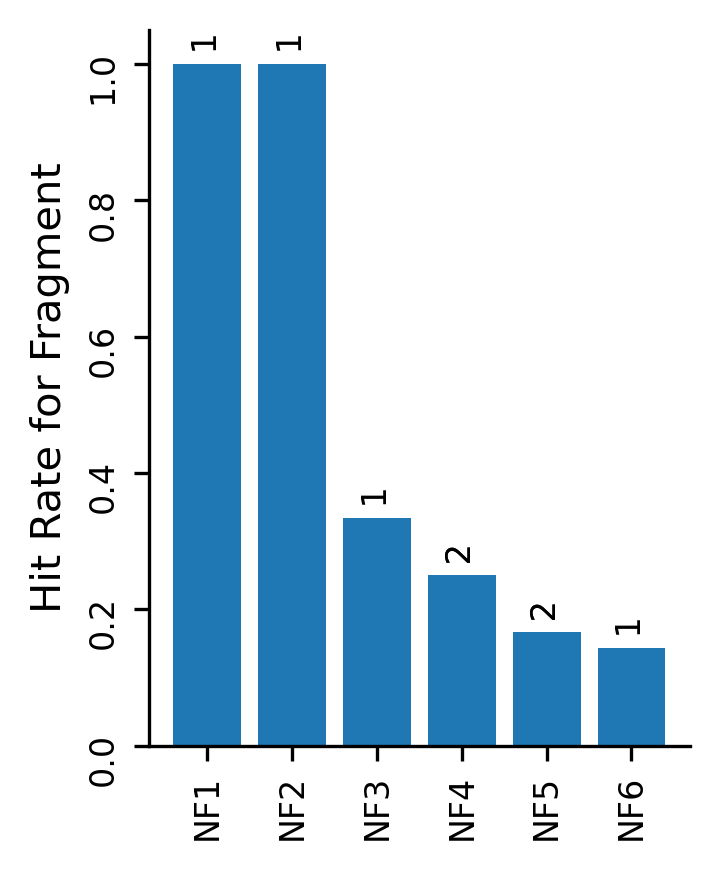

In [12]:
plot_fragment_hit_rates(hits, '../figs/figure_panels/successful_ng_frags', fig_size = (2.5,3), threshold_above_1 = False)

# Draw molecules with R groups

In [13]:
manual_mod_annot = {'SF1': [0,7], 
                   'SF18': [5],
                   'SF21': [0,14,6],
                   'SF22': [0],
                   'SF24': [0],
                   'SF25': [0,3], 
                   'SF31': [0, 6, 14, 12, 10, 18, 16],
                   'SF36': [0, 2, 4, 6]}
manual_mod_smi = {'SF1': 'COc2cc1nc(C)[nH]c1cc2Cl',
                 'SF18': 'Cc1noc(C)c1NC(=O)Nc2ccc(Cl)cc2',
                 'SF21': 'Cc3ccc(C(C)c1c[nH]c2ccc(C)cc12)cc3',
                 'SF22': 'CC(O)c1ccc(Cl)c(Cl)c1',
                 'SF24': 'CCC(O)c1ccc(Cl)c(Cl)c1', 
                 'SF25': 'CCC(C)c1ccc(Cl)c(Cl)c1', 
                 'SF31': 'Cc2ccc(C(C)c1cn(C)c(C)c1C)c(C)c2C', 
                 'SF36': 'CC(C)C(C)N(C)c1ccc(Cl)c(Cl)c1'}

skips = ['SF2', 'SF23', 'SF29']
for i, smalldf in hits1thru5.groupby('fragment_name'):
    if i in skips:
        continue
    idx = i.split('SF')[1]
    if int(idx) > 36:
        continue
    if len(smalldf) < 2:
        continue
    smi = list(smalldf['fragment_SMILES'])[0]
    print(i, smi)
    smi = manual_mod_smi[i]
    rgroups = manual_mod_annot[i]
    mol = Chem.MolFromSmiles(smi)
    for j, r in enumerate(rgroups):
        mol.GetAtomWithIdx(r).SetProp("_displayLabel","R<sub>" + str(j+1) + "</sub>")
    d2d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d2d.drawOptions().useBWAtomPalette()
    rdMolDraw2D.PrepareAndDrawMolecule(d2d,mol)
    d2d.WriteDrawingText('../figs/intermediate_data/fragments/fragments_alone_with_r_groups/' + i + 'test.png')
    

SF1 OC1=CC2=C(NC=N2)C=C1Cl
SF18 CC1=NOC=C1NC(=O)NC1=CC=C(Cl)C=C1
SF21 C(C1=CNC2=C1C=CC=C2)C1=CC=CC=C1
SF22 OCC1=CC=C(Cl)C(Cl)=C1
SF24 CC(O)C1=CC=C(Cl)C(Cl)=C1
SF25 CCC1=CC=C(Cl)C(Cl)=C1
SF31 C(C1=CNC=C1)C1=CC=CC=C1
SF36 CCNC1=CC=C(Cl)C(Cl)=C1


In [14]:
frags = ['*SC', '*C(F)(F)F', '*c2ccc1ccccc1c2', '*n1cc(C(=O)O)cn1', '*Cl', '*CC(=O)NCC2COc1ccccc1O2', '*CC(=O)NCC1(C)CCCO1', '*c1ccc(Cl)cc1', '*=O', '*C(=O)NCCc1ccccc1', '*C(=O)NCCC1CCCO1', '*C', '*c2nnc(COc1ccc(Cl)cc1Cl)o2']
for i, frag in enumerate(frags):
    mol = Chem.MolFromSmiles(frag)
    d2d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d2d.drawOptions().useBWAtomPalette()
    rdMolDraw2D.PrepareAndDrawMolecule(d2d,mol)
    d2d.WriteDrawingText('../figs/intermediate_data/fragments/fragments_alone_with_r_groups/frag' + str(i) + '.png')
    